In [1]:
import shap
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt 

import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier
import BlackBoxAuditing
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import CompasDataset, AdultDataset, StandardDataset, BankDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult


from aif360.algorithms.inprocessing import GerryFairClassifier
from aif360.algorithms.inprocessing import PrejudiceRemover

from sklearn.preprocessing import MinMaxScaler
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
import seaborn as sns

%matplotlib inline

## Step 1: Data loading

Here we provide a link to the shared csv file which you can use to read into your own working space on colaboratory.   

Link: https://drive.google.com/file/d/1SRuIuLtFanTmBhxa6qGuFi1j1rgM2DSz/view?usp=sharing

Let's use PyDrive to load the data.

In [3]:
# Load the same with information provided above in the link. 
filename = '2011.csv'
initial_data = pd.read_csv(filename, encoding='latin-1', low_memory=False)

In [4]:
# Check the data loaded.
initial_data.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2011,102,185,1012011,0,A,O,P,1,BURGLARY,...,,102,B,,,1030708,194185,CM,1,14
1,2011,115,50,1012011,5,A,O,P,1,FEL,...,,115,I,,,1021302,213563,CM,1,85
2,2011,100,4,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20
3,2011,100,3,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20
4,2011,100,1,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20


In [5]:
# Check size of dataset
initial_data.shape

(685724, 112)

In [6]:
# Check for presence of duplicate rows before filtering to relevant features
initial_data[initial_data.duplicated()].shape

(0, 112)

## Step 2: Data Preprocessing


In [7]:
# Get a summary of the dataset with pandas.  
initial_data.describe()

,year,pct,ser_num,datestop,timestop,perobs,perstop,compyear,comppct,revcmd,dob,age,ht_feet,ht_inch,weight,linecm,detailcm
count,685724.0,685724.000000,685724.000000,6.857240e+05,685724.000000,685724.000000,685724.000000,685724.0,685724.0,685724.000000,6.857240e+05,685724.000000,685724.000000,685724.000000,685724.000000,685724.0,685724.000000
mean,2011.0,67.375982,6327.886804,6.502490e+06,1435.877044,2.397559,5.571476,0.0,0.0,227.133444,8.939846e+06,29.398764,5.179049,6.415804,169.323824,1.0,41.331130
std,0.0,32.736376,5288.245687,3.467433e+06,727.141924,5.635170,12.795386,0.0,0.0,284.161860,3.839904e+06,37.221556,0.394506,3.342623,37.683693,0.0,27.462302
min,2011.0,1.000000,1.000000,1.012011e+06,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.011900e+06,0.000000,3.000000,0.000000,0.000000,1.0,1.000000
25%,2011.0,42.000000,2297.000000,3.252011e+06,1034.000000,1.000000,3.000000,0.0,0.0,63.000000,6.041988e+06,19.000000,5.000000,4.000000,150.000000,1.0,20.000000
50%,2011.0,71.000000,4961.000000,6.212011e+06,1630.000000,1.000000,5.000000,0.0,0.0,106.000000,1.031198e+07,24.000000,5.000000,7.000000,165.000000,1.0,29.000000
75%,2011.0,101.000000,9134.000000,9.302011e+06,2028.000000,2.000000,5.000000,0.0,0.0,165.000000,1.231190e+07,34.000000,5.000000,9.000000,180.000000,1.0,68.000000
max,2011.0,123.000000,31381.000000,1.231201e+07,2359.000000,955.000000,999.000000,0.0,0.0,881.000000,1.231200e+07,999.000000,7.000000,11.000000,999.000000,1.0,113.000000


In [8]:
# Extract relevant features (predictor and response) that will be utilized for analysis and remove those that will result in data leakage
# Precint (pct) is retained to clean city feature, but will be removed later on due to difficulty in binning them into separate pricints

# snf_data_pre = 'stop and frisk' data before preliminary processing
# Predictor features include description of suspect, officer behaviour and circumstances of the stop
# Response feature is whether the suspect was frisked
snf_data_pre = initial_data[['sex','race','age','ht_feet','ht_inch','weight','haircolr','eyecolor','build',
                            'city','pct','timestop','inout','trhsloc','typeofid','othpers',
                            'explnstp','offunif','officrid','offverb','offshld',
                            'ac_rept','ac_proxm','ac_evasv','ac_assoc','ac_cgdir','ac_incid','ac_time','ac_stsnd',
                            'frisked']].copy()

In [9]:
# Numeric features
snf_data_pre.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,685724.0,29.398764,37.221556,0.0,19.0,24.0,34.0,999.0
ht_feet,685724.0,5.179049,0.394506,3.0,5.0,5.0,5.0,7.0
ht_inch,685724.0,6.415804,3.342623,0.0,4.0,7.0,9.0,11.0
weight,685724.0,169.323824,37.683693,0.0,150.0,165.0,180.0,999.0
pct,685724.0,67.375982,32.736376,1.0,42.0,71.0,101.0,123.0
timestop,685724.0,1435.877044,727.141924,0.0,1034.0,1630.0,2028.0,2359.0


In [10]:
### Calculate total height of individuals in inches by combining ht_feet and ht_inch

# Create new column combining feet and inches into one number
snf_data_pre['ht_inch'] = (snf_data_pre['ht_feet'] * 12) + snf_data_pre['ht_inch']

# Delete feet column 
del snf_data_pre['ht_feet']

# Rename ht_inch to height
snf_data_pre.rename(columns={'ht_inch': 'height'}, inplace=True)

snf_data_pre.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,685724.0,29.398764,37.221556,0.0,19.0,24.0,34.0,999.0
height,685724.0,68.564389,3.181265,36.0,67.0,69.0,71.0,95.0
weight,685724.0,169.323824,37.683693,0.0,150.0,165.0,180.0,999.0
pct,685724.0,67.375982,32.736376,1.0,42.0,71.0,101.0,123.0
timestop,685724.0,1435.877044,727.141924,0.0,1034.0,1630.0,2028.0,2359.0


In [11]:
# Get data types
snf_data_pre.dtypes

sex         object
race        object
age          int64
height       int64
weight       int64
haircolr    object
eyecolor    object
build       object
city        object
pct          int64
timestop     int64
inout       object
trhsloc     object
typeofid    object
othpers     object
explnstp    object
offunif     object
officrid    object
offverb     object
offshld     object
ac_rept     object
ac_proxm    object
ac_evasv    object
ac_assoc    object
ac_cgdir    object
ac_incid    object
ac_time     object
ac_stsnd    object
frisked     object
dtype: object

In [12]:
# Get list of column names which are of type string (categorical) 
str_cols = snf_data_pre.select_dtypes(['object']).columns
str_cols

Index(['sex', 'race', 'haircolr', 'eyecolor', 'build', 'city', 'inout',
       'trhsloc', 'typeofid', 'othpers', 'explnstp', 'offunif', 'officrid',
       'offverb', 'offshld', 'ac_rept', 'ac_proxm', 'ac_evasv', 'ac_assoc',
       'ac_cgdir', 'ac_incid', 'ac_time', 'ac_stsnd', 'frisked'],
      dtype='object')

In [13]:
# String features 
snf_data_pre[str_cols].describe()
# There are a number of features with missing values (city, officrid, offverb, offshld)

,sex,race,haircolr,eyecolor,build,city,inout,trhsloc,typeofid,othpers,...,offshld,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,frisked
count,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724,...,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724
unique,3,8,11,13,5,6,2,3,4,2,...,2,2,2,2,2,2,2,2,2,2
top,M,B,BK,BR,M,BROOKLYN,O,P,P,N,...,,N,N,N,N,N,Y,N,N,Y
freq,626830,350743,519671,615932,402968,228324,545779,544854,368749,537590,...,512650,607202,539509,553879,657165,519347,407523,398181,668900,381704


**Handling missing values, unknown or inconsistent values**

In [14]:
# Create deep copy of dataframe in case there's need to revert to original dataframe
snf_data_toclean = snf_data_pre.copy()
snf_data_toclean.shape

(685724, 29)

In [15]:
# Replace empty values of parameters with Nan
snf_data_toclean.replace(to_replace=' ', value=np.NaN, inplace=True)

In [16]:
# Count number of empty values
snf_data_toclean.isnull().sum()

sex              0
race             0
age              0
height           0
weight           0
haircolr         0
eyecolor         0
build            0
city            38
pct              0
timestop         0
inout            0
trhsloc          0
typeofid         0
othpers          0
explnstp         0
offunif          0
officrid    677711
offverb     548624
offshld     512650
ac_rept          0
ac_proxm         0
ac_evasv         0
ac_assoc         0
ac_cgdir         0
ac_incid         0
ac_time          0
ac_stsnd         0
frisked          0
dtype: int64

In [17]:
# Impute missing city values using precint data

for i in [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='MANHATTAN'

for i in [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='BRONX'

for i in [60,61,62,63,66,67,68,69,70,71,72,73,75,76,77,78,79,81,83,84,88,90,94]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='BROOKLYN'

for i in [100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='QUEENS'

for i in [120,121,122,123]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='STATEN IS'

#Drop precint column as no longer needed
snf_data_toclean.drop(labels='pct', axis=1, inplace=True)

In [18]:
# As there isn't sufficient information to impute them, and deleting rows with missing values would result in loss of large portion of dataset, these columns will be dropped.
snf_data_toclean.drop(labels=['officrid', 'offverb', 'offshld'], axis=1, inplace=True)

# Replace all 'other' and 'unknown' values with NaN and drop those rows
snf_data_toclean = snf_data_toclean.replace(['Z', 'ZZ', 'XX'], np.NaN)
snf_data_toclean.dropna(inplace=True)

# Remove rows with value 'O' in typeofid column
snf_data_toclean = snf_data_toclean[snf_data_toclean['typeofid']!='O']

# Remove rows with value 'U' in race column
snf_data_toclean = snf_data_toclean[snf_data_toclean['race']!='U']

# Replace erroneous value on haircolor column
snf_data_toclean['haircolr'] = snf_data_toclean['haircolr'].replace({'RA': 'RD'})

# Replace erroneous value on eyecolor column
snf_data_toclean['eyecolor'] = snf_data_toclean['eyecolor'].replace({'MC':'MA', 'P':'PK'})



## Step 3: Data Exploration

In [19]:
# Create deep copy of processed dataset
snf_data_exp = snf_data_toclean.copy()
snf_data_exp.shape

(638447, 25)

In [20]:
# View dataframe
snf_data_exp.head()

,sex,race,age,height,weight,haircolr,eyecolor,build,city,timestop,...,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,frisked
0,M,A,21,68,182,BK,BR,M,QUEENS,0,...,N,N,N,N,N,N,Y,Y,N,Y
1,M,B,15,66,140,BK,BR,M,QUEENS,5,...,N,N,N,N,N,N,Y,N,N,Y
2,M,B,17,67,130,BK,BR,T,QUEENS,7,...,Y,N,Y,N,N,Y,N,Y,N,Y
3,M,B,17,67,130,BK,BR,T,QUEENS,7,...,Y,N,Y,N,N,Y,N,Y,N,Y
4,M,B,20,75,185,BK,BR,M,QUEENS,7,...,Y,N,Y,Y,N,Y,N,Y,N,Y


In [21]:
# View distribution of numerical data
snf_data_exp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,638447.0,29.179915,35.339250,0.0,19.0,24.0,34.0,999.0
height,638447.0,68.572174,3.143190,36.0,67.0,69.0,71.0,95.0
weight,638447.0,169.075388,33.913560,0.0,150.0,165.0,180.0,999.0
timestop,638447.0,1437.847773,727.732732,0.0,1035.0,1630.0,2030.0,2359.0


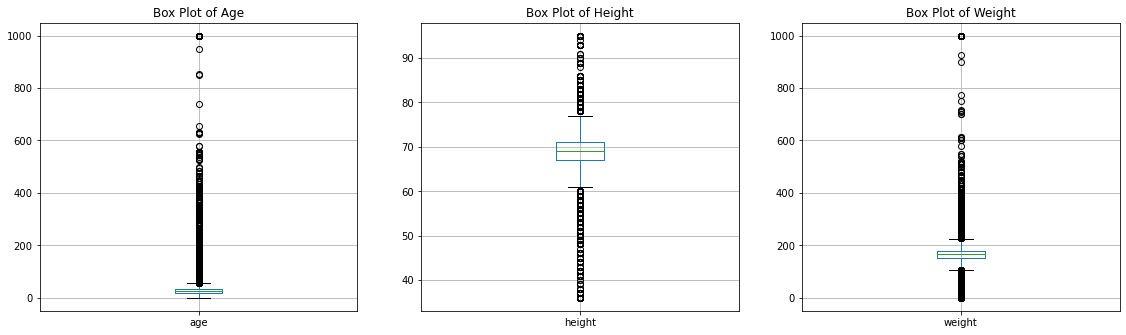

In [22]:

# Visualize distribution of ages, heights and weights using box plots
plt.subplot(131)
snf_data_exp.boxplot('age')
plt.title('Box Plot of Age')

plt.subplot(132)
snf_data_exp.boxplot('height')
plt.title('Box Plot of Height')

plt.subplot(133)
snf_data_exp.boxplot('weight')
plt.title('Box Plot of Weight')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1, wspace=0.2, hspace=0.2)

In [23]:
# Calculate upper and lower bounds of age, height and weight
print("Upper and Lower bounds")
for col in ['age', 'height', 'weight']:
    q1, q3 = np.percentile(snf_data_exp[col], [25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    print(col, lower_bound, upper_bound)

Upper and Lower bounds
age -3.5 56.5
height 61.0 77.0
weight 105.0 225.0


There exists erroneuous data in the age, height and weight parameters.


*   Oldest person in America is 114 years old - ages above 100 are likely erroneous. Average lifespan of an American is 76 years old. Ages that are too small (below 5 yrs) are likely noise too, as an infant wouldn't be stopped.
*   Tallest person in America is 7'8" (92 in) - any height above is erroneous. Heights that are too short (below 40 in) are assumed to be noise.
*   Average American weights are 159 to 191 lbs. Weights below 50 lbs and above 300 lbs are likely noise.

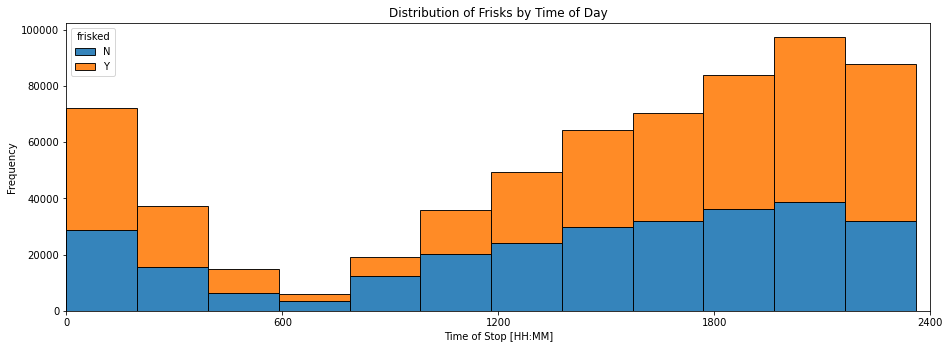

In [24]:
# Visualize distribution of frisks or no frisks by time of day
snf_data_exp.pivot(columns='frisked')['timestop'].plot(kind = 'hist', stacked=True, bins=12,alpha=0.9, edgecolor='black')
plt.xticks(np.arange(0,2500,step=600)); plt.xlim([0,2400])
plt.xlabel('Time of Stop [HH:MM]'); plt.title('Distribution of Frisks by Time of Day')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.2)

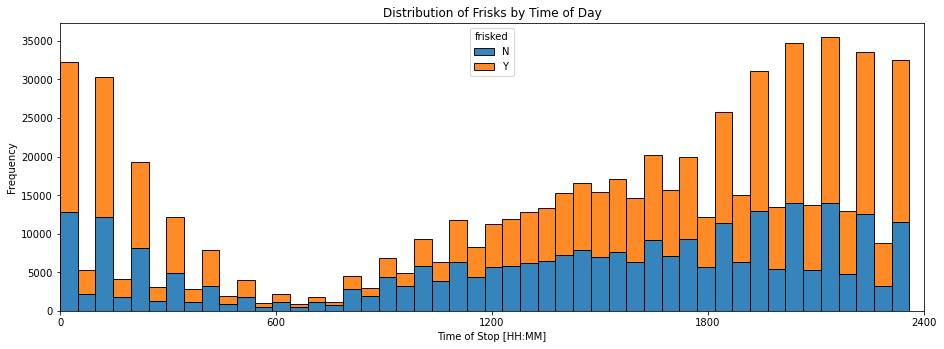

In [25]:
# Visualize distribution of frisks or no frisks by time of day
snf_data_exp.pivot(columns='frisked')['timestop'].plot(kind = 'hist', stacked=True, bins=48, alpha=0.9, edgecolor='black')
plt.xticks(np.arange(0,2500,step=600)); plt.xlim([0,2400])
plt.xlabel('Time of Stop [HH:MM]'); plt.title('Distribution of Frisks by Time of Day')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.2)

**Explore categorical attributes**

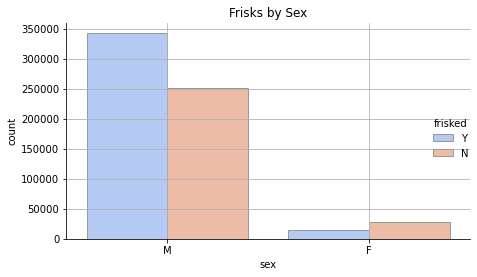

In [26]:
# Visualize frisks by sex
sns.catplot(x='sex', hue='frisked', data=snf_data_exp, kind='count', palette='coolwarm', edgecolor='0.6')
plt.title('Frisks by Sex'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=0.6, wspace=0.01, hspace=0.2)

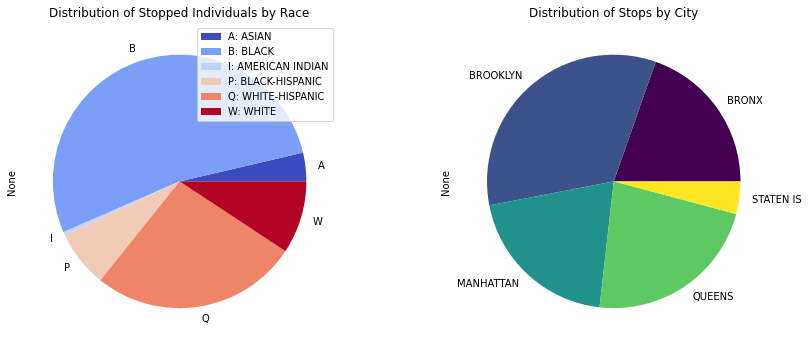

In [27]:
# Visualize distribution of race and city
plt.subplot(121)
snf_data_exp.groupby('race').size().plot.pie(colormap='coolwarm')
plt.legend(labels=('A: ASIAN','B: BLACK','I: AMERICAN INDIAN','P: BLACK-HISPANIC','Q: WHITE-HISPANIC','W: WHITE'))
plt.title('Distribution of Stopped Individuals by Race')

plt.subplot(122)
snf_data_exp.groupby('city').size().plot.pie(colormap='viridis')
plt.title('Distribution of Stops by City')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.1, wspace=0.01, hspace=0.2)

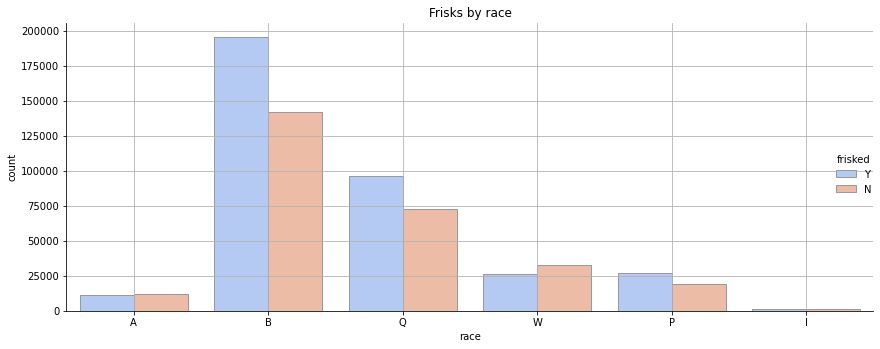

In [28]:
# Visualize frisks by race
sns.catplot(x='race', hue='frisked', data=snf_data_exp, kind='count', palette='coolwarm', edgecolor='0.6')
plt.title('Frisks by race'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

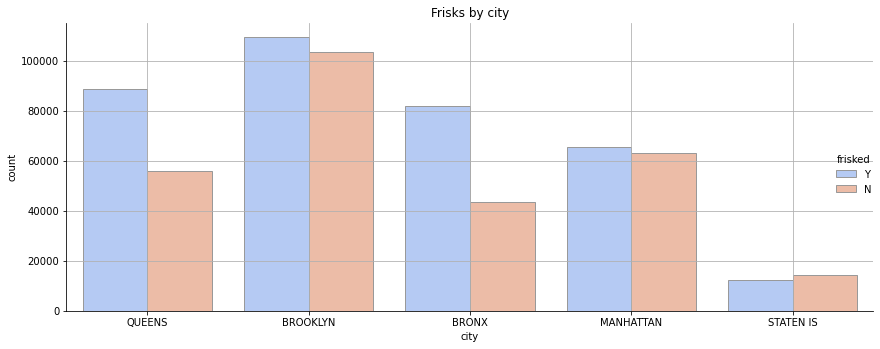

In [29]:
# Visualize frisks by city
sns.catplot(x='city', hue='frisked', data=snf_data_exp, kind='count', palette='coolwarm', edgecolor='0.6')
plt.title('Frisks by city'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

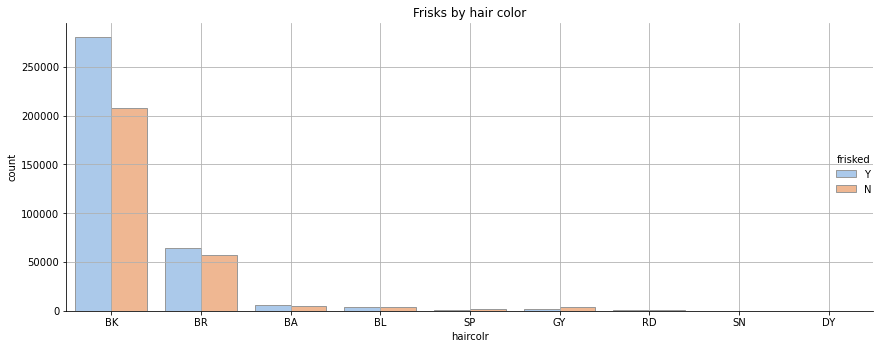

In [30]:
# Visualize frisks by hair color
sns.catplot(x='haircolr', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by hair color'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

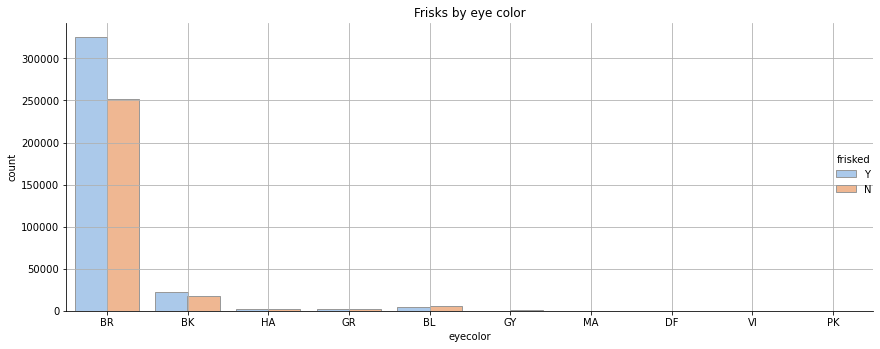

In [31]:
# Visualize frisks by eye color
sns.catplot(x='eyecolor', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by eye color'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

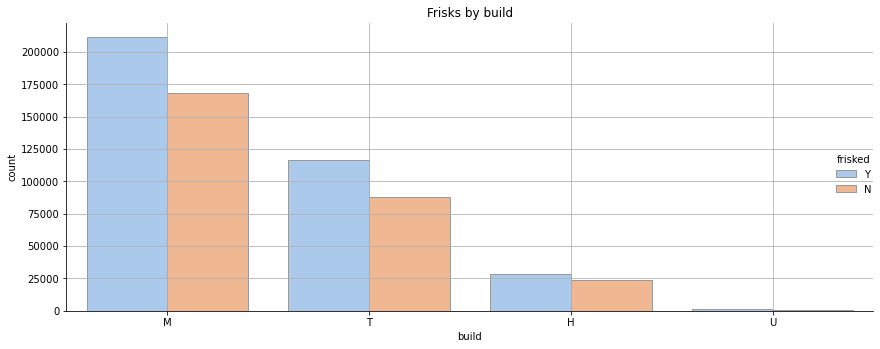

In [32]:
# Visualize frisks by build of body
sns.catplot(x='build', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by build'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)


In [33]:
pd.crosstab(columns=snf_data_exp['build'], index=snf_data_exp['frisked'], normalize=True, margins=True)

build,H,M,T,U,All
frisked,,,,,
N,0.037048,0.262836,0.137676,0.001345,0.438906
Y,0.044361,0.331735,0.182848,0.002151,0.561094
All,0.081408,0.594571,0.320525,0.003496,1.000000


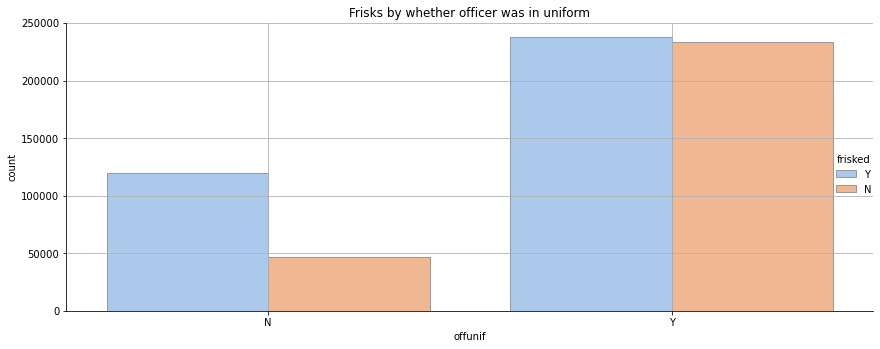

In [34]:
# Visualize frisks by if officer is in uniform
sns.catplot(x='offunif', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by whether officer was in uniform'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

In [35]:
# # Two way table
# print("Normalized Two-way Tables for categorical features")
# print()
# for i in str_cols[6:-1]:
#  print(pd.crosstab(columns=snf_data_exp[i], index=snf_data_exp['frisked'], margins=True, normalize=True).iloc[:,:-1])
#  print()

## Step 4: Feature Engineering

Some of the feature engineering like scaling needs to be done in the cross-validation loop, but some of the data may need to be engineered out on a global scale. These include removal of noise from data, conversion of categorical parameters into binary attributes, and sampling of dataset.

In [36]:
# Create deep copy of processed dataset
snf_data_feat = snf_data_toclean.copy()
snf_data_feat.shape

(638447, 25)

In [37]:
### Remove erroneous ages, heights and weights

# Remove rows with ages below 5 and above 100 years old 
snf_data_feat = snf_data_feat[(snf_data_feat['age']>=5) & (snf_data_feat['age']<=100)]

# Remove rows with heights below 40 in and above 90 in
snf_data_feat = snf_data_feat[(snf_data_feat['height']>=40) & (snf_data_feat['height']<=90)]

# Remove rows with weights below 50 lbs and above 300 lbs
snf_data_feat = snf_data_feat[(snf_data_feat['weight']>=50) & (snf_data_feat['weight']<=300)]

# Check if some rows were removed correctly 
snf_data_feat[['age','height','weight']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,634006.0,27.872288,11.670406,5.0,19.0,24.0,34.0,100.0
height,634006.0,68.570288,3.116178,40.0,67.0,69.0,71.0,90.0
weight,634006.0,168.677025,28.117731,50.0,150.0,165.0,180.0,300.0


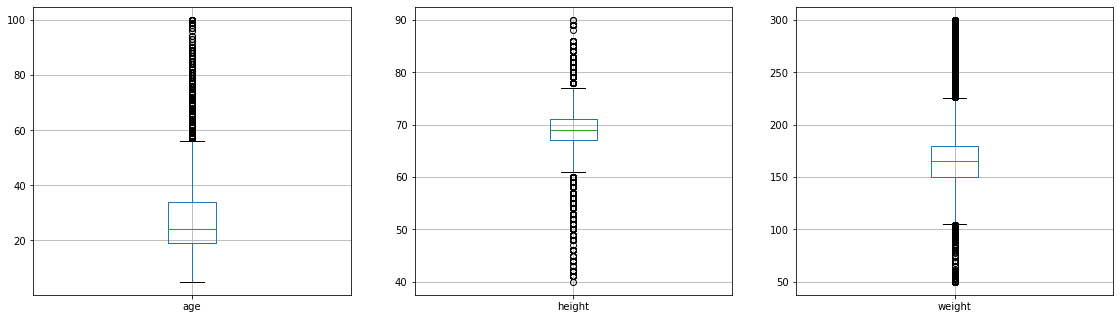

In [38]:
# Visualize distribution of ages, heights and weights
plt.subplot(131)
snf_data_feat.boxplot('age')
plt.subplot(132)
snf_data_feat.boxplot('height')
plt.subplot(133)
snf_data_feat.boxplot('weight')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1, wspace=0.2, hspace=0.2)

**Convert categorical values into binary attributes using binarization or One Hot Encoding**

In [39]:
### sex parameter 
# View unique values for sex parameter
print(snf_data_feat['sex'].value_counts())

# Convert sex parameter into binary
snf_data_feat['sex'] = snf_data_feat['sex'].replace({'M': 1, 'F': 0})

# Convert inout parameter into binary
snf_data_feat['inout'] = snf_data_feat['inout'].replace({'I': 1, 'O': 0})

M    590604
F     43402
Name: sex, dtype: int64


In [40]:


# Retrieve list of parameters with yes/no values
yesno_cols = ['othpers', 'explnstp', 'offunif', 'ac_rept', 'ac_proxm', 'ac_evasv', 'ac_assoc', 'ac_cgdir', 'ac_incid', 'ac_time', 'ac_stsnd']

# Convert Yes/No columns to integers (1/0)
snf_data_feat[yesno_cols] = snf_data_feat[yesno_cols].replace({'N':0, 'Y':1})


In [41]:
#list of parameters with more than 2 values
ohc_cols = ['race','haircolr', 'eyecolor', 'build', 'city', 'trhsloc', 'typeofid']
snf_data_feat['binary_race'] = snf_data_feat['race'].apply(lambda x: 1 if x=="W" else 0)
snf_data_feat['binary_frisked'] = snf_data_feat['frisked'].apply(lambda x: 1 if x=="Y" else 0)

# Convert all categorical data into binary using One Hot Encoding
ohc_df = pd.get_dummies(snf_data_feat[ohc_cols])

# Concatenate One Hot Encoding dataframe with original dataframe and the label (frisked) as the last column
snf_data_feat = pd.concat([snf_data_feat.iloc[:,:-1], ohc_df, snf_data_feat.iloc[:,-1]], axis=1)

# Remove columns
snf_data_feat.drop(ohc_cols, axis=1, inplace=True)
snf_data_feat.drop('frisked',axis=1, inplace=True)

In [42]:
snf_data_feat.head()

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,binary_frisked
0,1,21,68,182,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
1,1,15,66,140,5,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
2,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1
3,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1
4,1,20,75,185,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1


In [43]:
snf_data_feat.shape

(634006, 59)

In [44]:
snf_data_feat.corr()

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,binary_frisked
sex,1.000000,-0.010961,0.294459,0.210711,0.014857,-0.071588,-0.021644,0.001986,-0.051501,-0.044003,...,-0.024467,0.036774,-0.042268,-0.027697,0.028143,-0.007505,0.005486,-0.003969,-0.004313,0.119755
age,-0.010961,1.000000,0.061478,0.247722,-0.045528,0.054424,-0.125878,-0.004760,0.022932,-0.002146,...,0.104154,-0.034412,-0.006108,-0.035582,-0.026943,0.089185,0.137587,-0.015906,-0.133505,-0.123974
height,0.294459,0.061478,1.000000,0.464735,0.003982,-0.014926,-0.034360,0.001391,-0.046714,-0.015329,...,0.019580,-0.029138,0.000686,0.005411,-0.014080,0.014907,0.041612,0.008789,-0.044499,0.049886
weight,0.210711,0.247722,0.464735,1.000000,-0.014230,-0.019718,-0.049010,0.000509,-0.026914,-0.013281,...,0.022063,-0.000306,0.014420,-0.009202,0.003312,0.006965,0.088784,-0.001370,-0.088845,0.007169
timestop,0.014857,-0.045528,0.003982,-0.014230,1.000000,0.014473,-0.013078,0.001047,-0.018080,-0.060484,...,-0.030278,-0.054858,-0.009423,0.068611,-0.030588,-0.042694,-0.048693,0.007454,0.046695,0.035493
inout,-0.071588,0.054424,-0.014926,-0.019718,0.014473,1.000000,-0.082141,-0.000995,0.039533,0.027705,...,0.183776,-0.142961,-0.044475,0.223531,-0.533427,0.540282,-0.015110,0.020856,0.008871,-0.104736
othpers,-0.021644,-0.125878,-0.034360,-0.049010,-0.013078,-0.082141,1.000000,0.001387,-0.058366,0.059653,...,-0.006778,0.102612,0.005653,-0.078363,0.125462,-0.093022,-0.009682,-0.018009,0.015192,0.036528
explnstp,0.001986,-0.004760,0.001391,0.000509,0.001047,-0.000995,0.001387,1.000000,-0.000157,-0.001555,...,-0.003308,0.007543,0.002435,0.004973,-0.000707,-0.005459,0.001220,-0.006572,0.000765,0.004150
offunif,-0.051501,0.022932,-0.046714,-0.026914,-0.018080,0.039533,-0.058366,-0.000157,1.000000,0.080611,...,-0.072585,-0.021320,-0.041262,0.105905,-0.004070,-0.133474,0.058867,0.019953,-0.065229,-0.189466
ac_rept,-0.044003,-0.002146,-0.015329,-0.013281,-0.060484,0.027705,0.059653,-0.001555,0.080611,1.000000,...,0.020893,0.008664,0.021133,-0.041095,0.062975,-0.044365,0.014363,-0.006713,-0.012406,0.026531


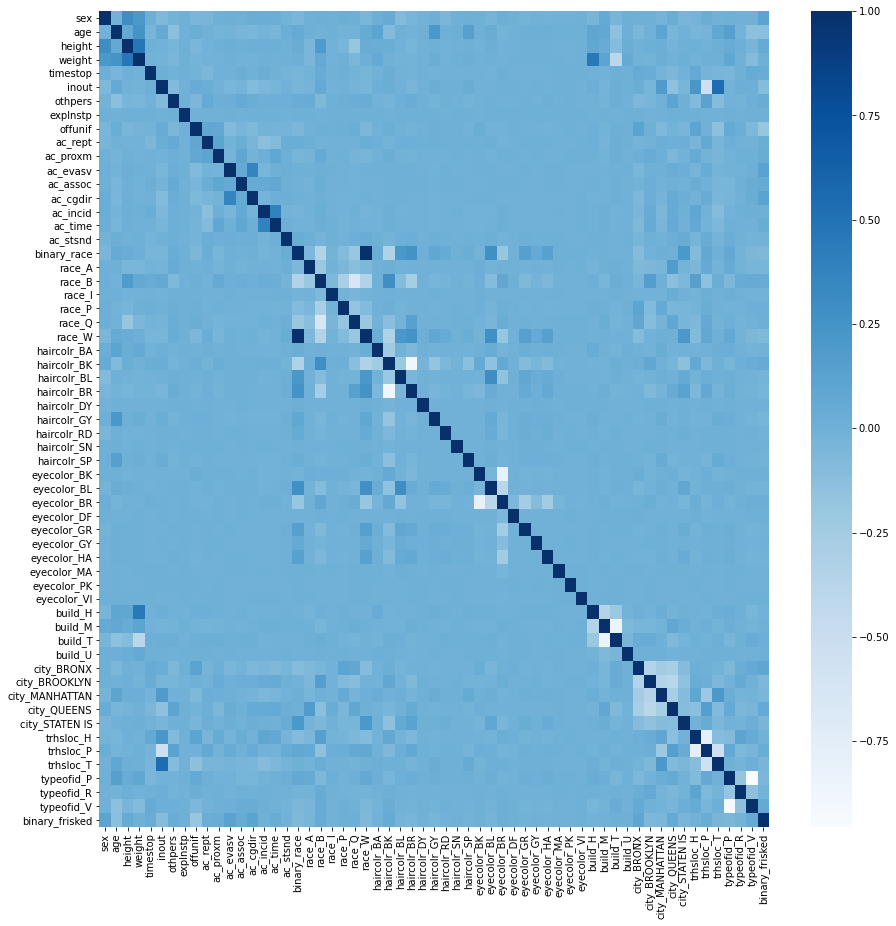

In [45]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(snf_data_feat.corr(), cmap="Blues", ax = ax)
plt.show()

## Step:5 Feature Selection using Random Forest Classifier

In [114]:
snf_data_feat_selec = snf_data_feat.copy()

In [115]:
# Perform feature selection using random forest classifier
x = snf_data_feat_selec.iloc[:,:-1]
y = snf_data_feat_selec.iloc[:,-1]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest_feat = RandomForestClassifier(random_state = 50)   # instantiate the random forest  
random_forest_feat = random_forest_feat.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest_feat.feature_importances_ # extract the expected feature importances
# std = np.std([tree.feature_importances_ for tree in random_forest_feat.estimators_],axis=0) # calculate stdev over trees
feat_ranks = np.argsort(importances)[::-1]   # find feature ranks in descending order

In [116]:
# Print feature ranking
print("Feature Ranking (The feature importance values sum to 1):")                 
for f in range(x.shape[1]):
    print("%d. %s (%.4f)" % (f + 1, x.columns.values[feat_ranks[f]], importances[feat_ranks[f]]))

Feature Ranking (The feature importance values sum to 1):
1. timestop (0.1978)
2. age (0.1510)
3. weight (0.1292)
4. height (0.1168)
5. offunif (0.0364)
6. ac_incid (0.0237)
7. ac_time (0.0213)
8. othpers (0.0196)
9. ac_proxm (0.0163)
10. ac_evasv (0.0151)
11. ac_cgdir (0.0145)
12. build_M (0.0143)
13. inout (0.0135)
14. build_T (0.0130)
15. ac_rept (0.0128)
16. sex (0.0126)
17. race_B (0.0109)
18. race_Q (0.0102)
19. haircolr_BK (0.0101)
20. city_BRONX (0.0099)
21. typeofid_P (0.0095)
22. city_BROOKLYN (0.0095)
23. typeofid_V (0.0095)
24. haircolr_BR (0.0093)
25. eyecolor_BR (0.0086)
26. city_MANHATTAN (0.0079)
27. city_QUEENS (0.0078)
28. trhsloc_P (0.0077)
29. build_H (0.0075)
30. trhsloc_H (0.0072)
31. eyecolor_BK (0.0071)
32. ac_assoc (0.0069)
33. race_P (0.0068)
34. ac_stsnd (0.0056)
35. trhsloc_T (0.0048)
36. race_A (0.0043)
37. city_STATEN IS (0.0042)
38. binary_race (0.0036)
39. race_W (0.0035)
40. typeofid_R (0.0033)
41. haircolr_BA (0.0030)
42. eyecolor_BL (0.0023)
43. hairc

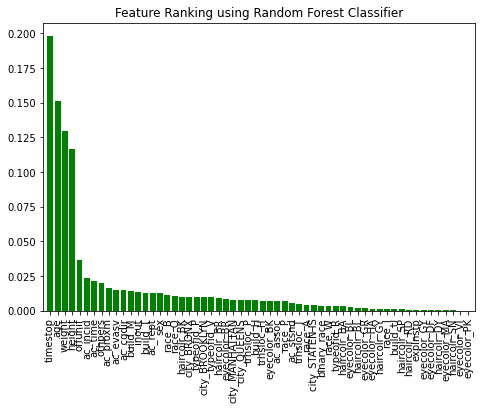

In [117]:
# Plot the feature importance                         
plt.title("Feature Ranking using Random Forest Classifier")
plt.bar(range(x.shape[1]), importances[feat_ranks], color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[feat_ranks], rotation=90)
plt.xlim([-1, x.shape[1]]); plt.ylim(0)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

## Step:6 Data Analysis

**Method 1: KNN**

In [46]:
# Define a pipeline to search for the best combination of 
# PCA dimensions and n_neighbors.
from sklearn.model_selection import GridSearchCV

snf_data_knn = snf_data_feat.copy()

#Separate label and drop label from data

train, test = train_test_split(snf_data_knn, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

print(train.shape)
print(test.shape)
print(val.shape)
y_train = train['binary_frisked']
x_train = train.drop('binary_frisked', axis=1)

y_test = test['binary_frisked']
x_test = test.drop('binary_frisked', axis=1)
# data_Y = snf_data_knn['frisked']
# data_X = snf_data_knn.drop('frisked', axis=1)

# #crate a scaler
scaler = sk.preprocessing.MinMaxScaler()

# #create a PCA
pca = PCA(n_components=9)

# #create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=29)
model = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])

#training
model.fit(x_train, y_train)


(456483, 59)
(126802, 59)
(50721, 59)


Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=9)),
                ('knn', KNeighborsClassifier(n_neighbors=29))])

## Step:7 Fairness Metrics

In [47]:
privileged_groups = [{'binary_race': 1}] # 1-> White
unprivileged_groups = [{'binary_race': 0}] # 0 -> Non White

In [48]:
def evaluate(model, X, y_true):
    '''Calculates the AUC and accuracy for a trained logistic regression model'''
    # Calculate predicted values
    y_pred = model.predict_proba(X)
    # This returns a tuple for each observation containing the probability of being in each class.
    # Since we're doing binary classification, all we need to know is the probability that the outcome = 1 (frisked)
    y_pred = [row[1] for row in y_pred] # This pulls the predicted probability that y = 1 for each observation

    # Calculate accuracy
    accuracy = accuracy_score(y_true, [pred_prob >= 0.5 for pred_prob in y_pred])
    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, auc

print(evaluate(model, x_test, y_test))

(0.6383416665352282, 0.6853844137791641)


In [119]:
def evaluateMetrics(model, data, x, y):
    test_preds_df = data.copy()
    test_preds_df['binary_frisked'] = model.predict(x)
    #favorable class is 0 (Not Frisked)
    orig_aif360 = StandardDataset(data, label_name='binary_frisked', protected_attribute_names=['binary_race'], 
                    privileged_classes=[[1]], favorable_classes=[0])
    preds_aif360 = StandardDataset(test_preds_df, label_name='binary_frisked', protected_attribute_names=['binary_race'], 
                    privileged_classes=[[1]], favorable_classes=[0])
    metric_aif360_train = BinaryLabelDatasetMetric(
        preds_aif360, 
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
    accuracy, auc =  evaluate(model, x_test, y_test)
    return accuracy, auc, metric_aif360_train.disparate_impact(), orig_vs_preds_metrics.accuracy(privileged=True), orig_vs_preds_metrics.accuracy(privileged=False), orig_vs_preds_metrics.false_positive_rate_difference()

In [68]:
accuracy, auc, Disparate_Impact, Accuracy_for_Priveleged, Accuracy_for_Unpriveleged, FPR = evaluateMetrics(model, test, x_test, y_test)
print("Reporting KNN Model...")
print("Accuracy ", accuracy*100)
print("AUC ", auc)
print("Disparate Impact ", Disparate_Impact)
print("Accuracy for Priveleged ", Accuracy_for_Priveleged)
print("Accuracy for Unpriveleged ", Accuracy_for_Unpriveleged)
print("False positive Rate difference", FPR)



Reporting KNN Model...
Accuracy  63.834166653522814
AUC  0.6853844137791641
Disparate Impact  0.5850977452901729
Accuracy for Priveleged  0.6440316946408793
Accuracy for Unpriveleged  0.6377612653717464
False positive Rate difference -0.21819742999727654


## Step: 8 SHAP

In [64]:
explainer = shap.KernelExplainer(model.predict_proba, shap.sample(x_test, 50))


In [65]:
shap_values = explainer.shap_values(x_test[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

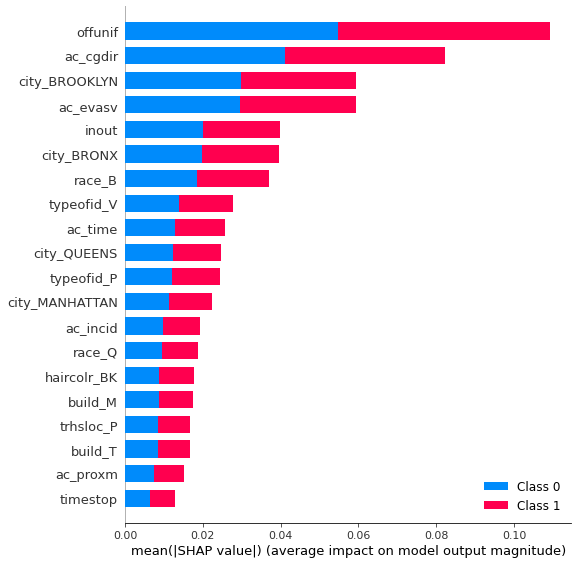

In [69]:
X_test_array = x_test[:50].to_numpy() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array,feature_names=x_test.columns)

In [111]:
shap.initjs()
id = 0
print("Frisked" if y_test.to_numpy()[id] else "Not Frisked")
print(test.to_numpy()[id])
shap.force_plot(explainer.expected_value[id], shap_values[id][0],x_test.iloc[id,:])

Frisked
[  1  23  65 140 426   0   0   1   1   1   0   0   0   1   1   1   0   0
   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0   1
   0   1   0   0   1]


In [107]:
shap.initjs()
id = 1
print("Frisked" if y_test.to_numpy()[id] else "Not Frisked")
print(test.to_numpy()[id])
shap.force_plot(explainer.expected_value[id], shap_values[id][0],x_test.iloc[id,:])

Frisked
[   1   38   68  130 2201    0    0    1    0    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    0    1    0    0
    0    0    0    0    0    0    0    1    0    0    0    0    0    0
    0    0    0    1    0    1    0    0    0    0    1    0    0    0
    0    1    1]


In [71]:
y_test = y_test.reset_index(drop=True)
misclassified_document = []
misclassified_label = []
y_pred = model.predict(x_test)
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        misclassified_document.append(i)
        misclassified_label.append(y_pred[i])
    
print("Number of Misclassified documents: ",len(misclassified_document)) 
print("Misclassified documents: ",(misclassified_document))

Number of Misclassified documents:  45859
Misclassified documents:  [2, 3, 6, 7, 10, 11, 17, 18, 20, 25, 27, 28, 29, 31, 34, 35, 36, 49, 50, 52, 54, 63, 65, 66, 68, 69, 70, 76, 77, 78, 86, 88, 94, 99, 100, 105, 107, 115, 117, 118, 120, 123, 125, 126, 127, 129, 136, 139, 144, 148, 149, 150, 151, 152, 153, 155, 162, 172, 174, 175, 178, 179, 181, 184, 185, 186, 190, 191, 192, 193, 196, 197, 200, 205, 208, 209, 215, 216, 222, 223, 231, 232, 236, 241, 244, 247, 252, 254, 257, 258, 260, 262, 266, 267, 268, 270, 275, 276, 280, 287, 289, 291, 293, 299, 303, 304, 309, 311, 313, 315, 316, 318, 322, 323, 325, 327, 330, 333, 334, 337, 339, 340, 344, 345, 347, 349, 350, 352, 353, 354, 355, 364, 366, 367, 371, 373, 375, 380, 381, 383, 384, 387, 391, 394, 397, 401, 402, 405, 407, 409, 410, 412, 413, 418, 424, 425, 427, 428, 441, 442, 443, 445, 446, 448, 453, 462, 463, 465, 466, 467, 471, 475, 477, 487, 488, 491, 493, 495, 499, 500, 501, 502, 503, 504, 505, 507, 513, 514, 518, 520, 524, 525, 526, 527,

In [72]:
x_test = x_test.reset_index(drop=True)
conf_i_list = []
for idx in misclassified_document:
    frisked = model.predict_proba([x_test.to_numpy()[idx]])[0][0]
    not_frisked = model.predict_proba([x_test.to_numpy()[idx]])[0][1]
    difference_prob = abs(frisked - not_frisked)
    conf_i_list.append(difference_prob)
    print("idx = ",idx," conf_i = ", difference_prob)
conf_i_list

idx =  2  conf_i =  0.7241379310344827
idx =  3  conf_i =  0.17241379310344823
idx =  6  conf_i =  0.17241379310344823
idx =  7  conf_i =  0.37931034482758624
idx =  10  conf_i =  0.37931034482758624
idx =  11  conf_i =  0.31034482758620685
idx =  17  conf_i =  0.17241379310344823
idx =  18  conf_i =  0.4482758620689655
idx =  20  conf_i =  0.31034482758620685
idx =  25  conf_i =  0.10344827586206895
idx =  27  conf_i =  0.4482758620689655
idx =  28  conf_i =  0.17241379310344823
idx =  29  conf_i =  0.24137931034482762
idx =  31  conf_i =  0.37931034482758624
idx =  34  conf_i =  0.31034482758620685
idx =  35  conf_i =  0.17241379310344823
idx =  36  conf_i =  0.7241379310344827
idx =  49  conf_i =  0.31034482758620685
idx =  50  conf_i =  0.03448275862068967
idx =  52  conf_i =  0.7931034482758621
idx =  54  conf_i =  0.24137931034482762
idx =  63  conf_i =  0.17241379310344823
idx =  65  conf_i =  0.24137931034482762
idx =  66  conf_i =  0.31034482758620685
idx =  68  conf_i =  0.10

idx =  540  conf_i =  0.31034482758620685
idx =  542  conf_i =  0.10344827586206895
idx =  551  conf_i =  0.31034482758620685
idx =  552  conf_i =  0.9310344827586208
idx =  564  conf_i =  0.24137931034482762
idx =  565  conf_i =  0.4482758620689655
idx =  568  conf_i =  0.10344827586206895
idx =  569  conf_i =  0.24137931034482762
idx =  574  conf_i =  0.10344827586206895
idx =  576  conf_i =  0.5172413793103448
idx =  578  conf_i =  0.17241379310344823
idx =  579  conf_i =  0.37931034482758624
idx =  581  conf_i =  0.37931034482758624
idx =  582  conf_i =  0.10344827586206895
idx =  584  conf_i =  0.5172413793103448
idx =  587  conf_i =  0.31034482758620685
idx =  588  conf_i =  0.10344827586206895
idx =  591  conf_i =  0.03448275862068967
idx =  593  conf_i =  0.03448275862068967
idx =  599  conf_i =  0.10344827586206895
idx =  605  conf_i =  0.17241379310344823
idx =  608  conf_i =  0.37931034482758624
idx =  609  conf_i =  0.03448275862068967
idx =  611  conf_i =  0.10344827586206

idx =  1097  conf_i =  0.17241379310344823
idx =  1098  conf_i =  0.37931034482758624
idx =  1104  conf_i =  0.6551724137931034
idx =  1107  conf_i =  0.31034482758620685
idx =  1116  conf_i =  0.7931034482758621
idx =  1117  conf_i =  0.6551724137931034
idx =  1118  conf_i =  0.7241379310344827
idx =  1120  conf_i =  0.4482758620689655
idx =  1128  conf_i =  0.31034482758620685
idx =  1131  conf_i =  0.31034482758620685
idx =  1133  conf_i =  0.03448275862068967
idx =  1136  conf_i =  0.10344827586206895
idx =  1139  conf_i =  0.03448275862068967
idx =  1140  conf_i =  0.24137931034482762
idx =  1145  conf_i =  0.31034482758620685
idx =  1146  conf_i =  0.31034482758620685
idx =  1147  conf_i =  0.10344827586206895
idx =  1152  conf_i =  0.10344827586206895
idx =  1155  conf_i =  0.6551724137931034
idx =  1156  conf_i =  0.31034482758620685
idx =  1157  conf_i =  0.17241379310344823
idx =  1161  conf_i =  0.17241379310344823
idx =  1170  conf_i =  0.03448275862068967
idx =  1172  conf

idx =  1665  conf_i =  0.6551724137931034
idx =  1666  conf_i =  0.10344827586206895
idx =  1669  conf_i =  0.24137931034482762
idx =  1672  conf_i =  0.17241379310344823
idx =  1677  conf_i =  0.03448275862068967
idx =  1686  conf_i =  0.4482758620689655
idx =  1688  conf_i =  0.5172413793103448
idx =  1690  conf_i =  0.17241379310344823
idx =  1692  conf_i =  0.03448275862068967
idx =  1694  conf_i =  0.17241379310344823
idx =  1695  conf_i =  0.4482758620689655
idx =  1697  conf_i =  0.10344827586206895
idx =  1698  conf_i =  0.4482758620689655
idx =  1699  conf_i =  0.10344827586206895
idx =  1700  conf_i =  0.9310344827586208
idx =  1703  conf_i =  0.31034482758620685
idx =  1705  conf_i =  0.03448275862068967
idx =  1706  conf_i =  0.17241379310344823
idx =  1708  conf_i =  0.03448275862068967
idx =  1709  conf_i =  0.5172413793103448
idx =  1712  conf_i =  0.10344827586206895
idx =  1713  conf_i =  0.37931034482758624
idx =  1714  conf_i =  0.31034482758620685
idx =  1717  conf_

idx =  2245  conf_i =  0.4482758620689655
idx =  2247  conf_i =  0.10344827586206895
idx =  2251  conf_i =  0.37931034482758624
idx =  2257  conf_i =  0.10344827586206895
idx =  2259  conf_i =  0.10344827586206895
idx =  2260  conf_i =  0.03448275862068967
idx =  2262  conf_i =  0.8620689655172413
idx =  2263  conf_i =  0.03448275862068967
idx =  2270  conf_i =  0.17241379310344823
idx =  2277  conf_i =  0.17241379310344823
idx =  2278  conf_i =  0.31034482758620685
idx =  2279  conf_i =  0.17241379310344823
idx =  2282  conf_i =  0.37931034482758624
idx =  2283  conf_i =  0.10344827586206895
idx =  2286  conf_i =  0.31034482758620685
idx =  2287  conf_i =  0.03448275862068967
idx =  2288  conf_i =  0.24137931034482762
idx =  2289  conf_i =  0.17241379310344823
idx =  2292  conf_i =  0.6551724137931034
idx =  2294  conf_i =  0.31034482758620685
idx =  2297  conf_i =  0.24137931034482762
idx =  2302  conf_i =  0.24137931034482762
idx =  2304  conf_i =  0.03448275862068967
idx =  2305  c

idx =  2735  conf_i =  0.5172413793103448
idx =  2739  conf_i =  0.17241379310344823
idx =  2741  conf_i =  0.4482758620689655
idx =  2742  conf_i =  0.31034482758620685
idx =  2749  conf_i =  0.10344827586206895
idx =  2750  conf_i =  0.10344827586206895
idx =  2752  conf_i =  0.24137931034482762
idx =  2759  conf_i =  0.4482758620689655
idx =  2760  conf_i =  0.03448275862068967
idx =  2761  conf_i =  0.10344827586206895
idx =  2766  conf_i =  0.10344827586206895
idx =  2767  conf_i =  0.03448275862068967
idx =  2768  conf_i =  0.17241379310344823
idx =  2773  conf_i =  0.10344827586206895
idx =  2775  conf_i =  0.24137931034482762
idx =  2779  conf_i =  0.5172413793103448
idx =  2785  conf_i =  0.10344827586206895
idx =  2787  conf_i =  0.5862068965517242
idx =  2788  conf_i =  0.03448275862068967
idx =  2796  conf_i =  0.37931034482758624
idx =  2804  conf_i =  0.31034482758620685
idx =  2810  conf_i =  0.5172413793103448
idx =  2813  conf_i =  0.03448275862068967
idx =  2814  conf

idx =  3307  conf_i =  0.10344827586206895
idx =  3309  conf_i =  0.31034482758620685
idx =  3310  conf_i =  0.31034482758620685
idx =  3317  conf_i =  0.37931034482758624
idx =  3319  conf_i =  0.03448275862068967
idx =  3326  conf_i =  0.10344827586206895
idx =  3327  conf_i =  0.03448275862068967
idx =  3331  conf_i =  0.10344827586206895
idx =  3334  conf_i =  0.37931034482758624
idx =  3340  conf_i =  0.03448275862068967
idx =  3343  conf_i =  0.31034482758620685
idx =  3344  conf_i =  0.6551724137931034
idx =  3345  conf_i =  0.03448275862068967
idx =  3356  conf_i =  0.10344827586206895
idx =  3363  conf_i =  0.17241379310344823
idx =  3365  conf_i =  0.24137931034482762
idx =  3375  conf_i =  0.03448275862068967
idx =  3377  conf_i =  0.10344827586206895
idx =  3379  conf_i =  0.24137931034482762
idx =  3382  conf_i =  0.10344827586206895
idx =  3383  conf_i =  0.6551724137931034
idx =  3384  conf_i =  0.37931034482758624
idx =  3387  conf_i =  0.31034482758620685
idx =  3390  

idx =  3886  conf_i =  0.17241379310344823
idx =  3887  conf_i =  0.24137931034482762
idx =  3890  conf_i =  0.03448275862068967
idx =  3892  conf_i =  0.4482758620689655
idx =  3896  conf_i =  0.24137931034482762
idx =  3901  conf_i =  0.17241379310344823
idx =  3903  conf_i =  0.03448275862068967
idx =  3906  conf_i =  0.37931034482758624
idx =  3907  conf_i =  0.17241379310344823
idx =  3912  conf_i =  0.5862068965517242
idx =  3913  conf_i =  0.17241379310344823
idx =  3916  conf_i =  0.31034482758620685
idx =  3919  conf_i =  0.03448275862068967
idx =  3922  conf_i =  0.4482758620689655
idx =  3932  conf_i =  0.5862068965517242
idx =  3937  conf_i =  0.10344827586206895
idx =  3940  conf_i =  0.10344827586206895
idx =  3942  conf_i =  0.03448275862068967
idx =  3944  conf_i =  0.37931034482758624
idx =  3949  conf_i =  0.31034482758620685
idx =  3950  conf_i =  0.31034482758620685
idx =  3952  conf_i =  0.03448275862068967
idx =  3953  conf_i =  0.17241379310344823
idx =  3956  co

idx =  4420  conf_i =  0.4482758620689655
idx =  4421  conf_i =  0.10344827586206895
idx =  4423  conf_i =  0.5172413793103448
idx =  4429  conf_i =  0.03448275862068967
idx =  4437  conf_i =  0.31034482758620685
idx =  4442  conf_i =  0.24137931034482762
idx =  4443  conf_i =  0.10344827586206895
idx =  4445  conf_i =  0.17241379310344823
idx =  4448  conf_i =  0.10344827586206895
idx =  4456  conf_i =  0.37931034482758624
idx =  4458  conf_i =  0.24137931034482762
idx =  4460  conf_i =  0.24137931034482762
idx =  4461  conf_i =  0.17241379310344823
idx =  4462  conf_i =  0.31034482758620685
idx =  4463  conf_i =  0.03448275862068967
idx =  4464  conf_i =  0.7241379310344827
idx =  4470  conf_i =  0.10344827586206895
idx =  4474  conf_i =  0.4482758620689655
idx =  4475  conf_i =  0.31034482758620685
idx =  4479  conf_i =  0.9310344827586208
idx =  4484  conf_i =  0.03448275862068967
idx =  4493  conf_i =  0.4482758620689655
idx =  4494  conf_i =  0.10344827586206895
idx =  4495  conf

idx =  4963  conf_i =  0.8620689655172413
idx =  4966  conf_i =  0.31034482758620685
idx =  4968  conf_i =  0.4482758620689655
idx =  4976  conf_i =  0.7931034482758621
idx =  4978  conf_i =  0.37931034482758624
idx =  4979  conf_i =  0.24137931034482762
idx =  4984  conf_i =  0.37931034482758624
idx =  4986  conf_i =  0.10344827586206895
idx =  4989  conf_i =  0.24137931034482762
idx =  4998  conf_i =  0.24137931034482762
idx =  4999  conf_i =  0.17241379310344823
idx =  5000  conf_i =  0.03448275862068967
idx =  5001  conf_i =  0.17241379310344823
idx =  5004  conf_i =  0.5172413793103448
idx =  5006  conf_i =  0.31034482758620685
idx =  5009  conf_i =  0.5172413793103448
idx =  5010  conf_i =  0.10344827586206895
idx =  5015  conf_i =  0.31034482758620685
idx =  5016  conf_i =  0.37931034482758624
idx =  5018  conf_i =  0.03448275862068967
idx =  5020  conf_i =  0.5862068965517242
idx =  5021  conf_i =  0.31034482758620685
idx =  5023  conf_i =  0.37931034482758624
idx =  5028  conf

idx =  5529  conf_i =  0.24137931034482762
idx =  5534  conf_i =  0.17241379310344823
idx =  5535  conf_i =  0.03448275862068967
idx =  5536  conf_i =  0.17241379310344823
idx =  5550  conf_i =  0.10344827586206895
idx =  5551  conf_i =  0.03448275862068967
idx =  5553  conf_i =  0.4482758620689655
idx =  5554  conf_i =  0.17241379310344823
idx =  5555  conf_i =  0.31034482758620685
idx =  5560  conf_i =  0.17241379310344823
idx =  5561  conf_i =  0.31034482758620685
idx =  5566  conf_i =  0.10344827586206895
idx =  5567  conf_i =  0.10344827586206895
idx =  5569  conf_i =  0.03448275862068967
idx =  5571  conf_i =  0.37931034482758624
idx =  5574  conf_i =  0.24137931034482762
idx =  5577  conf_i =  0.5172413793103448
idx =  5579  conf_i =  0.37931034482758624
idx =  5580  conf_i =  0.31034482758620685
idx =  5581  conf_i =  0.17241379310344823
idx =  5585  conf_i =  0.31034482758620685
idx =  5586  conf_i =  0.10344827586206895
idx =  5587  conf_i =  0.03448275862068967
idx =  5589  

idx =  6049  conf_i =  0.10344827586206895
idx =  6053  conf_i =  0.03448275862068967
idx =  6057  conf_i =  0.10344827586206895
idx =  6064  conf_i =  0.8620689655172413
idx =  6065  conf_i =  0.31034482758620685
idx =  6068  conf_i =  0.5172413793103448
idx =  6072  conf_i =  0.10344827586206895
idx =  6083  conf_i =  0.03448275862068967
idx =  6084  conf_i =  0.17241379310344823
idx =  6085  conf_i =  0.10344827586206895
idx =  6086  conf_i =  0.03448275862068967
idx =  6087  conf_i =  0.4482758620689655
idx =  6090  conf_i =  0.5172413793103448
idx =  6094  conf_i =  0.17241379310344823
idx =  6096  conf_i =  0.31034482758620685
idx =  6098  conf_i =  0.03448275862068967
idx =  6100  conf_i =  0.17241379310344823
idx =  6103  conf_i =  0.10344827586206895
idx =  6110  conf_i =  0.03448275862068967
idx =  6111  conf_i =  0.03448275862068967
idx =  6112  conf_i =  0.03448275862068967
idx =  6115  conf_i =  0.03448275862068967
idx =  6117  conf_i =  0.17241379310344823
idx =  6119  co

idx =  6593  conf_i =  0.5172413793103448
idx =  6594  conf_i =  0.10344827586206895
idx =  6597  conf_i =  0.5172413793103448
idx =  6599  conf_i =  0.17241379310344823
idx =  6602  conf_i =  0.24137931034482762
idx =  6605  conf_i =  0.03448275862068967
idx =  6606  conf_i =  0.5172413793103448
idx =  6607  conf_i =  0.03448275862068967
idx =  6610  conf_i =  0.10344827586206895
idx =  6615  conf_i =  0.4482758620689655
idx =  6617  conf_i =  0.10344827586206895
idx =  6618  conf_i =  0.31034482758620685
idx =  6619  conf_i =  0.17241379310344823
idx =  6623  conf_i =  0.31034482758620685
idx =  6627  conf_i =  0.03448275862068967
idx =  6630  conf_i =  0.5862068965517242
idx =  6631  conf_i =  0.10344827586206895
idx =  6633  conf_i =  0.03448275862068967
idx =  6635  conf_i =  0.17241379310344823
idx =  6642  conf_i =  0.37931034482758624
idx =  6646  conf_i =  0.24137931034482762
idx =  6650  conf_i =  0.24137931034482762
idx =  6652  conf_i =  0.10344827586206895
idx =  6653  con

idx =  7134  conf_i =  0.24137931034482762
idx =  7138  conf_i =  0.10344827586206895
idx =  7141  conf_i =  0.10344827586206895
idx =  7143  conf_i =  0.10344827586206895
idx =  7144  conf_i =  0.10344827586206895
idx =  7145  conf_i =  0.24137931034482762
idx =  7147  conf_i =  0.37931034482758624
idx =  7150  conf_i =  0.17241379310344823
idx =  7154  conf_i =  0.8620689655172413
idx =  7156  conf_i =  0.17241379310344823
idx =  7158  conf_i =  0.31034482758620685
idx =  7160  conf_i =  0.37931034482758624
idx =  7164  conf_i =  0.4482758620689655
idx =  7165  conf_i =  0.37931034482758624
idx =  7166  conf_i =  0.6551724137931034
idx =  7168  conf_i =  0.03448275862068967
idx =  7169  conf_i =  0.03448275862068967
idx =  7171  conf_i =  0.7241379310344827
idx =  7174  conf_i =  0.17241379310344823
idx =  7175  conf_i =  0.31034482758620685
idx =  7177  conf_i =  0.24137931034482762
idx =  7179  conf_i =  0.10344827586206895
idx =  7186  conf_i =  0.03448275862068967
idx =  7187  co

idx =  7702  conf_i =  0.24137931034482762
idx =  7706  conf_i =  0.17241379310344823
idx =  7713  conf_i =  0.24137931034482762
idx =  7718  conf_i =  0.5862068965517242
idx =  7725  conf_i =  0.17241379310344823
idx =  7729  conf_i =  0.10344827586206895
idx =  7730  conf_i =  0.17241379310344823
idx =  7742  conf_i =  0.03448275862068967
idx =  7744  conf_i =  0.17241379310344823
idx =  7746  conf_i =  0.10344827586206895
idx =  7747  conf_i =  0.10344827586206895
idx =  7754  conf_i =  0.17241379310344823
idx =  7760  conf_i =  0.10344827586206895
idx =  7762  conf_i =  0.24137931034482762
idx =  7764  conf_i =  0.8620689655172413
idx =  7765  conf_i =  0.37931034482758624
idx =  7766  conf_i =  0.31034482758620685
idx =  7767  conf_i =  0.03448275862068967
idx =  7772  conf_i =  0.03448275862068967
idx =  7773  conf_i =  0.10344827586206895
idx =  7777  conf_i =  0.17241379310344823
idx =  7779  conf_i =  0.10344827586206895
idx =  7783  conf_i =  0.31034482758620685
idx =  7786  

idx =  8238  conf_i =  0.03448275862068967
idx =  8241  conf_i =  0.10344827586206895
idx =  8249  conf_i =  0.17241379310344823
idx =  8251  conf_i =  0.03448275862068967
idx =  8256  conf_i =  0.31034482758620685
idx =  8257  conf_i =  0.37931034482758624
idx =  8259  conf_i =  0.03448275862068967
idx =  8260  conf_i =  0.5172413793103448
idx =  8263  conf_i =  0.31034482758620685
idx =  8265  conf_i =  0.03448275862068967
idx =  8266  conf_i =  0.10344827586206895
idx =  8267  conf_i =  0.31034482758620685
idx =  8279  conf_i =  0.37931034482758624
idx =  8283  conf_i =  0.24137931034482762
idx =  8285  conf_i =  0.6551724137931034
idx =  8286  conf_i =  0.37931034482758624
idx =  8288  conf_i =  0.03448275862068967
idx =  8289  conf_i =  0.03448275862068967
idx =  8290  conf_i =  0.6551724137931034
idx =  8296  conf_i =  0.4482758620689655
idx =  8297  conf_i =  0.31034482758620685
idx =  8301  conf_i =  0.10344827586206895
idx =  8305  conf_i =  0.37931034482758624
idx =  8306  co

idx =  8775  conf_i =  0.03448275862068967
idx =  8777  conf_i =  0.17241379310344823
idx =  8778  conf_i =  0.31034482758620685
idx =  8783  conf_i =  0.24137931034482762
idx =  8785  conf_i =  1.0
idx =  8788  conf_i =  0.37931034482758624
idx =  8789  conf_i =  0.03448275862068967
idx =  8790  conf_i =  0.03448275862068967
idx =  8792  conf_i =  0.5172413793103448
idx =  8796  conf_i =  0.03448275862068967
idx =  8798  conf_i =  0.31034482758620685
idx =  8802  conf_i =  0.24137931034482762
idx =  8803  conf_i =  0.03448275862068967
idx =  8805  conf_i =  0.4482758620689655
idx =  8806  conf_i =  0.4482758620689655
idx =  8808  conf_i =  0.5862068965517242
idx =  8809  conf_i =  0.37931034482758624
idx =  8816  conf_i =  0.5172413793103448
idx =  8820  conf_i =  0.5172413793103448
idx =  8822  conf_i =  0.24137931034482762
idx =  8824  conf_i =  0.5862068965517242
idx =  8825  conf_i =  0.03448275862068967
idx =  8826  conf_i =  0.10344827586206895
idx =  8830  conf_i =  0.310344827

idx =  9311  conf_i =  0.31034482758620685
idx =  9315  conf_i =  0.03448275862068967
idx =  9320  conf_i =  0.5862068965517242
idx =  9321  conf_i =  0.24137931034482762
idx =  9323  conf_i =  0.31034482758620685
idx =  9324  conf_i =  0.17241379310344823
idx =  9325  conf_i =  0.10344827586206895
idx =  9328  conf_i =  0.10344827586206895
idx =  9334  conf_i =  0.37931034482758624
idx =  9336  conf_i =  0.6551724137931034
idx =  9339  conf_i =  0.03448275862068967
idx =  9342  conf_i =  0.6551724137931034
idx =  9343  conf_i =  0.7931034482758621
idx =  9346  conf_i =  0.24137931034482762
idx =  9353  conf_i =  0.4482758620689655
idx =  9356  conf_i =  0.17241379310344823
idx =  9361  conf_i =  0.8620689655172413
idx =  9362  conf_i =  0.17241379310344823
idx =  9364  conf_i =  0.17241379310344823
idx =  9368  conf_i =  0.37931034482758624
idx =  9370  conf_i =  0.4482758620689655
idx =  9371  conf_i =  0.03448275862068967
idx =  9375  conf_i =  0.10344827586206895
idx =  9379  conf_

idx =  9869  conf_i =  0.03448275862068967
idx =  9870  conf_i =  0.03448275862068967
idx =  9874  conf_i =  0.17241379310344823
idx =  9875  conf_i =  0.03448275862068967
idx =  9877  conf_i =  0.10344827586206895
idx =  9880  conf_i =  0.37931034482758624
idx =  9885  conf_i =  0.37931034482758624
idx =  9887  conf_i =  0.10344827586206895
idx =  9890  conf_i =  0.37931034482758624
idx =  9893  conf_i =  0.31034482758620685
idx =  9895  conf_i =  0.17241379310344823
idx =  9897  conf_i =  0.10344827586206895
idx =  9899  conf_i =  0.03448275862068967
idx =  9902  conf_i =  0.6551724137931034
idx =  9903  conf_i =  0.31034482758620685
idx =  9905  conf_i =  0.24137931034482762
idx =  9907  conf_i =  0.10344827586206895
idx =  9910  conf_i =  0.37931034482758624
idx =  9913  conf_i =  0.5172413793103448
idx =  9915  conf_i =  0.37931034482758624
idx =  9916  conf_i =  0.17241379310344823
idx =  9917  conf_i =  0.10344827586206895
idx =  9920  conf_i =  0.7241379310344827
idx =  9921  c

idx =  10366  conf_i =  0.37931034482758624
idx =  10367  conf_i =  0.10344827586206895
idx =  10369  conf_i =  0.5172413793103448
idx =  10370  conf_i =  0.5862068965517242
idx =  10371  conf_i =  0.31034482758620685
idx =  10378  conf_i =  0.24137931034482762
idx =  10381  conf_i =  0.4482758620689655
idx =  10383  conf_i =  0.37931034482758624
idx =  10384  conf_i =  0.24137931034482762
idx =  10387  conf_i =  0.24137931034482762
idx =  10389  conf_i =  0.24137931034482762
idx =  10391  conf_i =  0.03448275862068967
idx =  10395  conf_i =  0.37931034482758624
idx =  10397  conf_i =  0.8620689655172413
idx =  10398  conf_i =  0.10344827586206895
idx =  10399  conf_i =  0.17241379310344823
idx =  10402  conf_i =  0.17241379310344823
idx =  10403  conf_i =  0.4482758620689655
idx =  10404  conf_i =  0.10344827586206895
idx =  10405  conf_i =  0.17241379310344823
idx =  10413  conf_i =  0.03448275862068967
idx =  10414  conf_i =  0.5172413793103448
idx =  10415  conf_i =  0.172413793103

idx =  10859  conf_i =  0.17241379310344823
idx =  10860  conf_i =  0.5172413793103448
idx =  10866  conf_i =  0.10344827586206895
idx =  10869  conf_i =  0.5172413793103448
idx =  10871  conf_i =  0.24137931034482762
idx =  10875  conf_i =  0.17241379310344823
idx =  10878  conf_i =  0.24137931034482762
idx =  10879  conf_i =  0.17241379310344823
idx =  10883  conf_i =  0.24137931034482762
idx =  10887  conf_i =  0.31034482758620685
idx =  10892  conf_i =  1.0
idx =  10893  conf_i =  0.7241379310344827
idx =  10897  conf_i =  0.10344827586206895
idx =  10898  conf_i =  0.5172413793103448
idx =  10900  conf_i =  0.03448275862068967
idx =  10903  conf_i =  0.5172413793103448
idx =  10906  conf_i =  0.6551724137931034
idx =  10907  conf_i =  0.10344827586206895
idx =  10913  conf_i =  0.5862068965517242
idx =  10918  conf_i =  0.7931034482758621
idx =  10922  conf_i =  0.03448275862068967
idx =  10923  conf_i =  0.6551724137931034
idx =  10928  conf_i =  0.10344827586206895
idx =  10930 

idx =  11370  conf_i =  0.5172413793103448
idx =  11371  conf_i =  0.24137931034482762
idx =  11372  conf_i =  0.24137931034482762
idx =  11373  conf_i =  0.5862068965517242
idx =  11376  conf_i =  0.10344827586206895
idx =  11379  conf_i =  0.24137931034482762
idx =  11383  conf_i =  0.4482758620689655
idx =  11384  conf_i =  0.31034482758620685
idx =  11387  conf_i =  0.5862068965517242
idx =  11389  conf_i =  0.31034482758620685
idx =  11390  conf_i =  0.7931034482758621
idx =  11391  conf_i =  0.10344827586206895
idx =  11397  conf_i =  0.17241379310344823
idx =  11400  conf_i =  0.37931034482758624
idx =  11404  conf_i =  0.37931034482758624
idx =  11406  conf_i =  0.37931034482758624
idx =  11408  conf_i =  0.17241379310344823
idx =  11411  conf_i =  0.37931034482758624
idx =  11416  conf_i =  0.03448275862068967
idx =  11417  conf_i =  0.24137931034482762
idx =  11419  conf_i =  0.17241379310344823
idx =  11421  conf_i =  0.7241379310344827
idx =  11422  conf_i =  0.034482758620

idx =  11920  conf_i =  0.31034482758620685
idx =  11921  conf_i =  0.03448275862068967
idx =  11923  conf_i =  0.03448275862068967
idx =  11924  conf_i =  0.17241379310344823
idx =  11928  conf_i =  0.17241379310344823
idx =  11932  conf_i =  0.03448275862068967
idx =  11933  conf_i =  0.5172413793103448
idx =  11934  conf_i =  0.17241379310344823
idx =  11936  conf_i =  0.4482758620689655
idx =  11939  conf_i =  0.37931034482758624
idx =  11949  conf_i =  0.31034482758620685
idx =  11950  conf_i =  0.24137931034482762
idx =  11951  conf_i =  0.17241379310344823
idx =  11953  conf_i =  0.37931034482758624
idx =  11960  conf_i =  0.03448275862068967
idx =  11961  conf_i =  0.7241379310344827
idx =  11962  conf_i =  0.17241379310344823
idx =  11964  conf_i =  0.31034482758620685
idx =  11967  conf_i =  0.03448275862068967
idx =  11968  conf_i =  0.10344827586206895
idx =  11969  conf_i =  0.37931034482758624
idx =  11971  conf_i =  0.24137931034482762
idx =  11974  conf_i =  0.379310344

idx =  12440  conf_i =  0.7241379310344827
idx =  12441  conf_i =  0.5862068965517242
idx =  12442  conf_i =  0.17241379310344823
idx =  12445  conf_i =  0.37931034482758624
idx =  12446  conf_i =  0.31034482758620685
idx =  12448  conf_i =  0.24137931034482762
idx =  12449  conf_i =  0.37931034482758624
idx =  12455  conf_i =  0.03448275862068967
idx =  12457  conf_i =  0.8620689655172413
idx =  12458  conf_i =  0.31034482758620685
idx =  12465  conf_i =  0.03448275862068967
idx =  12466  conf_i =  0.17241379310344823
idx =  12469  conf_i =  0.24137931034482762
idx =  12472  conf_i =  0.10344827586206895
idx =  12473  conf_i =  0.5862068965517242
idx =  12482  conf_i =  0.31034482758620685
idx =  12485  conf_i =  0.5172413793103448
idx =  12486  conf_i =  0.4482758620689655
idx =  12495  conf_i =  0.10344827586206895
idx =  12496  conf_i =  0.10344827586206895
idx =  12498  conf_i =  0.17241379310344823
idx =  12500  conf_i =  0.03448275862068967
idx =  12502  conf_i =  0.103448275862

idx =  12964  conf_i =  0.10344827586206895
idx =  12965  conf_i =  0.03448275862068967
idx =  12967  conf_i =  0.37931034482758624
idx =  12970  conf_i =  0.17241379310344823
idx =  12971  conf_i =  0.31034482758620685
idx =  12974  conf_i =  0.6551724137931034
idx =  12980  conf_i =  0.5172413793103448
idx =  12982  conf_i =  0.4482758620689655
idx =  12988  conf_i =  0.03448275862068967
idx =  12992  conf_i =  0.03448275862068967
idx =  13006  conf_i =  0.8620689655172413
idx =  13009  conf_i =  0.24137931034482762
idx =  13010  conf_i =  0.31034482758620685
idx =  13011  conf_i =  0.4482758620689655
idx =  13016  conf_i =  0.37931034482758624
idx =  13018  conf_i =  0.03448275862068967
idx =  13019  conf_i =  0.5172413793103448
idx =  13022  conf_i =  0.17241379310344823
idx =  13025  conf_i =  0.17241379310344823
idx =  13026  conf_i =  0.31034482758620685
idx =  13027  conf_i =  0.03448275862068967
idx =  13029  conf_i =  0.03448275862068967
idx =  13031  conf_i =  0.172413793103

idx =  13472  conf_i =  0.4482758620689655
idx =  13473  conf_i =  0.03448275862068967
idx =  13477  conf_i =  0.10344827586206895
idx =  13478  conf_i =  0.5172413793103448
idx =  13479  conf_i =  0.4482758620689655
idx =  13482  conf_i =  0.10344827586206895
idx =  13485  conf_i =  0.24137931034482762
idx =  13490  conf_i =  0.17241379310344823
idx =  13493  conf_i =  0.10344827586206895
idx =  13496  conf_i =  0.37931034482758624
idx =  13497  conf_i =  0.03448275862068967
idx =  13504  conf_i =  0.24137931034482762
idx =  13507  conf_i =  0.24137931034482762
idx =  13514  conf_i =  0.37931034482758624
idx =  13516  conf_i =  0.17241379310344823
idx =  13517  conf_i =  0.10344827586206895
idx =  13518  conf_i =  0.03448275862068967
idx =  13521  conf_i =  0.5172413793103448
idx =  13522  conf_i =  0.31034482758620685
idx =  13523  conf_i =  0.31034482758620685
idx =  13528  conf_i =  0.03448275862068967
idx =  13540  conf_i =  0.24137931034482762
idx =  13544  conf_i =  0.3793103448

idx =  14006  conf_i =  0.03448275862068967
idx =  14008  conf_i =  0.9310344827586208
idx =  14013  conf_i =  0.31034482758620685
idx =  14015  conf_i =  0.5172413793103448
idx =  14017  conf_i =  0.31034482758620685
idx =  14018  conf_i =  0.24137931034482762
idx =  14020  conf_i =  0.10344827586206895
idx =  14022  conf_i =  0.4482758620689655
idx =  14024  conf_i =  0.4482758620689655
idx =  14029  conf_i =  0.37931034482758624
idx =  14030  conf_i =  0.24137931034482762
idx =  14033  conf_i =  0.24137931034482762
idx =  14034  conf_i =  0.4482758620689655
idx =  14036  conf_i =  0.6551724137931034
idx =  14037  conf_i =  0.03448275862068967
idx =  14040  conf_i =  0.5862068965517242
idx =  14043  conf_i =  0.4482758620689655
idx =  14044  conf_i =  0.03448275862068967
idx =  14046  conf_i =  0.5172413793103448
idx =  14047  conf_i =  0.31034482758620685
idx =  14051  conf_i =  0.31034482758620685
idx =  14053  conf_i =  0.17241379310344823
idx =  14057  conf_i =  0.103448275862068

idx =  14477  conf_i =  0.5862068965517242
idx =  14478  conf_i =  0.5172413793103448
idx =  14479  conf_i =  0.17241379310344823
idx =  14483  conf_i =  0.03448275862068967
idx =  14486  conf_i =  0.10344827586206895
idx =  14487  conf_i =  0.24137931034482762
idx =  14488  conf_i =  0.5172413793103448
idx =  14491  conf_i =  0.24137931034482762
idx =  14492  conf_i =  0.9310344827586208
idx =  14493  conf_i =  0.17241379310344823
idx =  14496  conf_i =  0.37931034482758624
idx =  14497  conf_i =  0.31034482758620685
idx =  14498  conf_i =  0.5862068965517242
idx =  14499  conf_i =  0.17241379310344823
idx =  14501  conf_i =  0.17241379310344823
idx =  14502  conf_i =  0.37931034482758624
idx =  14503  conf_i =  0.31034482758620685
idx =  14508  conf_i =  0.4482758620689655
idx =  14514  conf_i =  0.4482758620689655
idx =  14515  conf_i =  0.24137931034482762
idx =  14516  conf_i =  0.6551724137931034
idx =  14517  conf_i =  0.03448275862068967
idx =  14520  conf_i =  0.03448275862068

idx =  15000  conf_i =  0.6551724137931034
idx =  15001  conf_i =  0.03448275862068967
idx =  15002  conf_i =  0.24137931034482762
idx =  15005  conf_i =  0.37931034482758624
idx =  15006  conf_i =  0.4482758620689655
idx =  15007  conf_i =  0.5172413793103448
idx =  15009  conf_i =  0.37931034482758624
idx =  15013  conf_i =  0.17241379310344823
idx =  15019  conf_i =  0.17241379310344823
idx =  15020  conf_i =  0.4482758620689655
idx =  15021  conf_i =  0.24137931034482762
idx =  15022  conf_i =  0.17241379310344823
idx =  15023  conf_i =  0.10344827586206895
idx =  15025  conf_i =  0.37931034482758624
idx =  15030  conf_i =  0.24137931034482762
idx =  15031  conf_i =  0.31034482758620685
idx =  15037  conf_i =  0.5862068965517242
idx =  15044  conf_i =  0.24137931034482762
idx =  15045  conf_i =  0.37931034482758624
idx =  15051  conf_i =  0.5172413793103448
idx =  15053  conf_i =  0.37931034482758624
idx =  15054  conf_i =  0.10344827586206895
idx =  15055  conf_i =  0.448275862068

idx =  15572  conf_i =  0.17241379310344823
idx =  15576  conf_i =  0.10344827586206895
idx =  15577  conf_i =  0.31034482758620685
idx =  15582  conf_i =  0.03448275862068967
idx =  15584  conf_i =  0.17241379310344823
idx =  15590  conf_i =  0.5172413793103448
idx =  15594  conf_i =  0.10344827586206895
idx =  15595  conf_i =  0.03448275862068967
idx =  15597  conf_i =  0.24137931034482762
idx =  15598  conf_i =  0.10344827586206895
idx =  15599  conf_i =  0.17241379310344823
idx =  15603  conf_i =  0.17241379310344823
idx =  15604  conf_i =  0.03448275862068967
idx =  15607  conf_i =  0.03448275862068967
idx =  15608  conf_i =  0.37931034482758624
idx =  15617  conf_i =  0.31034482758620685
idx =  15620  conf_i =  0.4482758620689655
idx =  15623  conf_i =  0.31034482758620685
idx =  15624  conf_i =  0.24137931034482762
idx =  15625  conf_i =  0.10344827586206895
idx =  15626  conf_i =  0.10344827586206895
idx =  15631  conf_i =  0.5172413793103448
idx =  15634  conf_i =  0.103448275

idx =  16133  conf_i =  0.37931034482758624
idx =  16137  conf_i =  0.24137931034482762
idx =  16138  conf_i =  0.03448275862068967
idx =  16142  conf_i =  0.37931034482758624
idx =  16143  conf_i =  0.03448275862068967
idx =  16145  conf_i =  0.31034482758620685
idx =  16146  conf_i =  0.5172413793103448
idx =  16155  conf_i =  0.17241379310344823
idx =  16156  conf_i =  0.5172413793103448
idx =  16159  conf_i =  0.4482758620689655
idx =  16164  conf_i =  0.10344827586206895
idx =  16166  conf_i =  0.17241379310344823
idx =  16167  conf_i =  0.10344827586206895
idx =  16168  conf_i =  0.17241379310344823
idx =  16172  conf_i =  0.17241379310344823
idx =  16174  conf_i =  0.24137931034482762
idx =  16176  conf_i =  0.4482758620689655
idx =  16179  conf_i =  0.10344827586206895
idx =  16185  conf_i =  0.24137931034482762
idx =  16189  conf_i =  0.24137931034482762
idx =  16197  conf_i =  0.10344827586206895
idx =  16198  conf_i =  0.03448275862068967
idx =  16202  conf_i =  0.1724137931

idx =  16686  conf_i =  0.24137931034482762
idx =  16687  conf_i =  0.10344827586206895
idx =  16690  conf_i =  0.17241379310344823
idx =  16695  conf_i =  0.37931034482758624
idx =  16701  conf_i =  0.24137931034482762
idx =  16705  conf_i =  0.17241379310344823
idx =  16708  conf_i =  0.4482758620689655
idx =  16711  conf_i =  0.10344827586206895
idx =  16713  conf_i =  0.17241379310344823
idx =  16716  conf_i =  0.03448275862068967
idx =  16718  conf_i =  0.03448275862068967
idx =  16721  conf_i =  0.31034482758620685
idx =  16722  conf_i =  0.31034482758620685
idx =  16723  conf_i =  0.4482758620689655
idx =  16732  conf_i =  0.37931034482758624
idx =  16733  conf_i =  0.10344827586206895
idx =  16735  conf_i =  0.17241379310344823
idx =  16737  conf_i =  0.37931034482758624
idx =  16738  conf_i =  0.5862068965517242
idx =  16745  conf_i =  0.5172413793103448
idx =  16749  conf_i =  0.10344827586206895
idx =  16754  conf_i =  0.31034482758620685
idx =  16756  conf_i =  0.1034482758

idx =  17255  conf_i =  0.17241379310344823
idx =  17256  conf_i =  0.10344827586206895
idx =  17257  conf_i =  0.17241379310344823
idx =  17260  conf_i =  0.17241379310344823
idx =  17262  conf_i =  0.24137931034482762
idx =  17264  conf_i =  0.03448275862068967
idx =  17267  conf_i =  0.4482758620689655
idx =  17271  conf_i =  0.37931034482758624
idx =  17274  conf_i =  0.8620689655172413
idx =  17277  conf_i =  0.03448275862068967
idx =  17279  conf_i =  0.31034482758620685
idx =  17282  conf_i =  0.10344827586206895
idx =  17290  conf_i =  0.24137931034482762
idx =  17295  conf_i =  0.03448275862068967
idx =  17298  conf_i =  0.17241379310344823
idx =  17299  conf_i =  0.03448275862068967
idx =  17300  conf_i =  0.17241379310344823
idx =  17301  conf_i =  0.03448275862068967
idx =  17315  conf_i =  0.5172413793103448
idx =  17316  conf_i =  0.03448275862068967
idx =  17325  conf_i =  0.10344827586206895
idx =  17327  conf_i =  0.31034482758620685
idx =  17328  conf_i =  0.724137931

idx =  17807  conf_i =  0.4482758620689655
idx =  17811  conf_i =  0.37931034482758624
idx =  17814  conf_i =  0.7241379310344827
idx =  17817  conf_i =  0.4482758620689655
idx =  17822  conf_i =  0.7241379310344827
idx =  17826  conf_i =  0.31034482758620685
idx =  17833  conf_i =  0.24137931034482762
idx =  17836  conf_i =  0.10344827586206895
idx =  17837  conf_i =  0.10344827586206895
idx =  17840  conf_i =  0.37931034482758624
idx =  17843  conf_i =  0.37931034482758624
idx =  17844  conf_i =  0.31034482758620685
idx =  17849  conf_i =  0.31034482758620685
idx =  17850  conf_i =  0.17241379310344823
idx =  17854  conf_i =  0.4482758620689655
idx =  17856  conf_i =  0.37931034482758624
idx =  17863  conf_i =  0.03448275862068967
idx =  17865  conf_i =  0.5172413793103448
idx =  17868  conf_i =  0.37931034482758624
idx =  17871  conf_i =  0.31034482758620685
idx =  17873  conf_i =  0.10344827586206895
idx =  17876  conf_i =  0.4482758620689655
idx =  17882  conf_i =  0.2413793103448

idx =  18350  conf_i =  0.4482758620689655
idx =  18355  conf_i =  0.10344827586206895
idx =  18357  conf_i =  0.10344827586206895
idx =  18358  conf_i =  0.4482758620689655
idx =  18363  conf_i =  0.17241379310344823
idx =  18364  conf_i =  0.10344827586206895
idx =  18368  conf_i =  0.31034482758620685
idx =  18378  conf_i =  0.37931034482758624
idx =  18380  conf_i =  0.03448275862068967
idx =  18381  conf_i =  0.5862068965517242
idx =  18382  conf_i =  0.24137931034482762
idx =  18384  conf_i =  0.17241379310344823
idx =  18385  conf_i =  0.7931034482758621
idx =  18389  conf_i =  0.31034482758620685
idx =  18390  conf_i =  0.03448275862068967
idx =  18391  conf_i =  0.5172413793103448
idx =  18393  conf_i =  0.17241379310344823
idx =  18394  conf_i =  0.03448275862068967
idx =  18395  conf_i =  0.24137931034482762
idx =  18396  conf_i =  0.5862068965517242
idx =  18399  conf_i =  0.03448275862068967
idx =  18400  conf_i =  0.5862068965517242
idx =  18409  conf_i =  0.7931034482758

idx =  18897  conf_i =  0.10344827586206895
idx =  18898  conf_i =  0.03448275862068967
idx =  18905  conf_i =  0.17241379310344823
idx =  18907  conf_i =  0.7241379310344827
idx =  18908  conf_i =  0.17241379310344823
idx =  18916  conf_i =  0.8620689655172413
idx =  18917  conf_i =  0.03448275862068967
idx =  18918  conf_i =  0.6551724137931034
idx =  18920  conf_i =  0.17241379310344823
idx =  18925  conf_i =  0.24137931034482762
idx =  18927  conf_i =  0.17241379310344823
idx =  18928  conf_i =  0.5172413793103448
idx =  18929  conf_i =  0.37931034482758624
idx =  18930  conf_i =  0.10344827586206895
idx =  18932  conf_i =  0.31034482758620685
idx =  18938  conf_i =  0.17241379310344823
idx =  18949  conf_i =  0.4482758620689655
idx =  18950  conf_i =  0.10344827586206895
idx =  18952  conf_i =  0.03448275862068967
idx =  18959  conf_i =  0.17241379310344823
idx =  18960  conf_i =  0.31034482758620685
idx =  18961  conf_i =  0.17241379310344823
idx =  18965  conf_i =  0.03448275862

idx =  19467  conf_i =  0.10344827586206895
idx =  19469  conf_i =  0.17241379310344823
idx =  19471  conf_i =  0.8620689655172413
idx =  19472  conf_i =  0.10344827586206895
idx =  19473  conf_i =  0.37931034482758624
idx =  19477  conf_i =  0.4482758620689655
idx =  19478  conf_i =  0.10344827586206895
idx =  19479  conf_i =  0.03448275862068967
idx =  19489  conf_i =  0.03448275862068967
idx =  19492  conf_i =  0.24137931034482762
idx =  19495  conf_i =  0.10344827586206895
idx =  19497  conf_i =  0.37931034482758624
idx =  19501  conf_i =  0.10344827586206895
idx =  19502  conf_i =  0.10344827586206895
idx =  19506  conf_i =  0.03448275862068967
idx =  19508  conf_i =  0.5862068965517242
idx =  19509  conf_i =  0.31034482758620685
idx =  19513  conf_i =  0.17241379310344823
idx =  19519  conf_i =  0.24137931034482762
idx =  19521  conf_i =  0.24137931034482762
idx =  19523  conf_i =  0.31034482758620685
idx =  19526  conf_i =  0.31034482758620685
idx =  19529  conf_i =  0.310344827

idx =  20035  conf_i =  0.17241379310344823
idx =  20038  conf_i =  0.37931034482758624
idx =  20040  conf_i =  0.31034482758620685
idx =  20041  conf_i =  0.5172413793103448
idx =  20044  conf_i =  0.4482758620689655
idx =  20050  conf_i =  0.31034482758620685
idx =  20051  conf_i =  0.03448275862068967
idx =  20052  conf_i =  0.10344827586206895
idx =  20053  conf_i =  0.24137931034482762
idx =  20057  conf_i =  0.6551724137931034
idx =  20065  conf_i =  0.7931034482758621
idx =  20070  conf_i =  0.03448275862068967
idx =  20071  conf_i =  0.03448275862068967
idx =  20077  conf_i =  0.24137931034482762
idx =  20080  conf_i =  0.6551724137931034
idx =  20081  conf_i =  0.24137931034482762
idx =  20083  conf_i =  0.4482758620689655
idx =  20089  conf_i =  0.4482758620689655
idx =  20092  conf_i =  0.31034482758620685
idx =  20094  conf_i =  0.4482758620689655
idx =  20100  conf_i =  0.03448275862068967
idx =  20102  conf_i =  0.37931034482758624
idx =  20105  conf_i =  0.31034482758620

idx =  20626  conf_i =  0.37931034482758624
idx =  20631  conf_i =  0.10344827586206895
idx =  20633  conf_i =  0.10344827586206895
idx =  20634  conf_i =  0.17241379310344823
idx =  20636  conf_i =  0.5172413793103448
idx =  20638  conf_i =  0.31034482758620685
idx =  20640  conf_i =  0.4482758620689655
idx =  20641  conf_i =  0.17241379310344823
idx =  20642  conf_i =  0.17241379310344823
idx =  20648  conf_i =  0.17241379310344823
idx =  20649  conf_i =  0.31034482758620685
idx =  20653  conf_i =  0.6551724137931034
idx =  20655  conf_i =  0.03448275862068967
idx =  20663  conf_i =  0.03448275862068967
idx =  20664  conf_i =  0.10344827586206895
idx =  20665  conf_i =  0.7931034482758621
idx =  20666  conf_i =  0.24137931034482762
idx =  20668  conf_i =  0.17241379310344823
idx =  20669  conf_i =  0.5862068965517242
idx =  20672  conf_i =  0.17241379310344823
idx =  20673  conf_i =  0.5172413793103448
idx =  20675  conf_i =  0.37931034482758624
idx =  20678  conf_i =  0.310344827586

idx =  21099  conf_i =  0.24137931034482762
idx =  21100  conf_i =  0.24137931034482762
idx =  21101  conf_i =  0.31034482758620685
idx =  21103  conf_i =  0.10344827586206895
idx =  21105  conf_i =  0.31034482758620685
idx =  21107  conf_i =  0.5172413793103448
idx =  21110  conf_i =  1.0
idx =  21111  conf_i =  0.37931034482758624
idx =  21113  conf_i =  0.37931034482758624
idx =  21115  conf_i =  0.24137931034482762
idx =  21119  conf_i =  0.03448275862068967
idx =  21120  conf_i =  0.10344827586206895
idx =  21121  conf_i =  0.17241379310344823
idx =  21123  conf_i =  0.7241379310344827
idx =  21126  conf_i =  0.5862068965517242
idx =  21127  conf_i =  0.17241379310344823
idx =  21128  conf_i =  0.31034482758620685
idx =  21130  conf_i =  0.5172413793103448
idx =  21131  conf_i =  0.10344827586206895
idx =  21133  conf_i =  0.17241379310344823
idx =  21134  conf_i =  0.5862068965517242
idx =  21139  conf_i =  0.10344827586206895
idx =  21142  conf_i =  0.7241379310344827
idx =  211

idx =  21629  conf_i =  0.03448275862068967
idx =  21630  conf_i =  0.7931034482758621
idx =  21636  conf_i =  0.8620689655172413
idx =  21637  conf_i =  0.37931034482758624
idx =  21640  conf_i =  0.24137931034482762
idx =  21644  conf_i =  0.24137931034482762
idx =  21645  conf_i =  0.37931034482758624
idx =  21646  conf_i =  0.4482758620689655
idx =  21650  conf_i =  0.5862068965517242
idx =  21652  conf_i =  0.17241379310344823
idx =  21660  conf_i =  0.24137931034482762
idx =  21661  conf_i =  0.31034482758620685
idx =  21664  conf_i =  0.17241379310344823
idx =  21670  conf_i =  0.37931034482758624
idx =  21675  conf_i =  0.10344827586206895
idx =  21678  conf_i =  0.5172413793103448
idx =  21681  conf_i =  0.31034482758620685
idx =  21683  conf_i =  0.4482758620689655
idx =  21684  conf_i =  0.6551724137931034
idx =  21690  conf_i =  0.10344827586206895
idx =  21693  conf_i =  0.03448275862068967
idx =  21702  conf_i =  0.5862068965517242
idx =  21703  conf_i =  0.03448275862068

idx =  22139  conf_i =  0.37931034482758624
idx =  22141  conf_i =  0.4482758620689655
idx =  22144  conf_i =  0.6551724137931034
idx =  22146  conf_i =  0.6551724137931034
idx =  22147  conf_i =  0.03448275862068967
idx =  22152  conf_i =  0.5862068965517242
idx =  22154  conf_i =  0.03448275862068967
idx =  22155  conf_i =  0.24137931034482762
idx =  22157  conf_i =  0.24137931034482762
idx =  22158  conf_i =  0.10344827586206895
idx =  22161  conf_i =  0.03448275862068967
idx =  22173  conf_i =  0.4482758620689655
idx =  22175  conf_i =  0.03448275862068967
idx =  22179  conf_i =  0.03448275862068967
idx =  22182  conf_i =  0.5172413793103448
idx =  22183  conf_i =  0.31034482758620685
idx =  22184  conf_i =  0.17241379310344823
idx =  22186  conf_i =  0.31034482758620685
idx =  22187  conf_i =  0.31034482758620685
idx =  22189  conf_i =  0.37931034482758624
idx =  22190  conf_i =  0.5172413793103448
idx =  22191  conf_i =  0.17241379310344823
idx =  22194  conf_i =  0.1034482758620

idx =  22662  conf_i =  0.24137931034482762
idx =  22666  conf_i =  0.03448275862068967
idx =  22678  conf_i =  0.03448275862068967
idx =  22680  conf_i =  0.24137931034482762
idx =  22682  conf_i =  0.37931034482758624
idx =  22686  conf_i =  0.4482758620689655
idx =  22691  conf_i =  0.24137931034482762
idx =  22692  conf_i =  0.10344827586206895
idx =  22702  conf_i =  0.4482758620689655
idx =  22706  conf_i =  0.17241379310344823
idx =  22707  conf_i =  0.37931034482758624
idx =  22710  conf_i =  0.10344827586206895
idx =  22712  conf_i =  0.24137931034482762
idx =  22713  conf_i =  0.4482758620689655
idx =  22718  conf_i =  0.24137931034482762
idx =  22720  conf_i =  0.4482758620689655
idx =  22725  conf_i =  0.03448275862068967
idx =  22727  conf_i =  0.37931034482758624
idx =  22728  conf_i =  0.10344827586206895
idx =  22729  conf_i =  0.03448275862068967
idx =  22731  conf_i =  0.17241379310344823
idx =  22734  conf_i =  0.10344827586206895
idx =  22739  conf_i =  0.1034482758

idx =  23212  conf_i =  0.37931034482758624
idx =  23213  conf_i =  0.31034482758620685
idx =  23216  conf_i =  0.24137931034482762
idx =  23217  conf_i =  0.03448275862068967
idx =  23218  conf_i =  0.03448275862068967
idx =  23219  conf_i =  0.37931034482758624
idx =  23220  conf_i =  0.17241379310344823
idx =  23222  conf_i =  0.03448275862068967
idx =  23230  conf_i =  0.10344827586206895
idx =  23232  conf_i =  0.24137931034482762
idx =  23233  conf_i =  0.17241379310344823
idx =  23238  conf_i =  0.31034482758620685
idx =  23239  conf_i =  0.5862068965517242
idx =  23240  conf_i =  0.37931034482758624
idx =  23243  conf_i =  0.5172413793103448
idx =  23246  conf_i =  0.5172413793103448
idx =  23250  conf_i =  0.03448275862068967
idx =  23255  conf_i =  0.17241379310344823
idx =  23258  conf_i =  0.5172413793103448
idx =  23262  conf_i =  0.6551724137931034
idx =  23263  conf_i =  0.4482758620689655
idx =  23270  conf_i =  0.10344827586206895
idx =  23273  conf_i =  0.034482758620

idx =  23738  conf_i =  0.24137931034482762
idx =  23740  conf_i =  0.4482758620689655
idx =  23744  conf_i =  0.31034482758620685
idx =  23745  conf_i =  0.7241379310344827
idx =  23747  conf_i =  0.31034482758620685
idx =  23753  conf_i =  0.37931034482758624
idx =  23755  conf_i =  0.4482758620689655
idx =  23757  conf_i =  0.5172413793103448
idx =  23758  conf_i =  0.17241379310344823
idx =  23759  conf_i =  0.31034482758620685
idx =  23767  conf_i =  0.37931034482758624
idx =  23768  conf_i =  0.4482758620689655
idx =  23770  conf_i =  0.7931034482758621
idx =  23771  conf_i =  0.10344827586206895
idx =  23773  conf_i =  0.24137931034482762
idx =  23776  conf_i =  0.03448275862068967
idx =  23778  conf_i =  0.10344827586206895
idx =  23780  conf_i =  0.10344827586206895
idx =  23785  conf_i =  0.24137931034482762
idx =  23788  conf_i =  0.03448275862068967
idx =  23793  conf_i =  0.03448275862068967
idx =  23794  conf_i =  0.17241379310344823
idx =  23799  conf_i =  0.172413793103

idx =  24196  conf_i =  0.03448275862068967
idx =  24199  conf_i =  0.4482758620689655
idx =  24202  conf_i =  0.03448275862068967
idx =  24203  conf_i =  0.5862068965517242
idx =  24205  conf_i =  0.31034482758620685
idx =  24206  conf_i =  0.03448275862068967
idx =  24207  conf_i =  0.10344827586206895
idx =  24213  conf_i =  0.31034482758620685
idx =  24214  conf_i =  0.24137931034482762
idx =  24227  conf_i =  0.31034482758620685
idx =  24228  conf_i =  0.17241379310344823
idx =  24234  conf_i =  0.03448275862068967
idx =  24236  conf_i =  0.24137931034482762
idx =  24238  conf_i =  0.10344827586206895
idx =  24242  conf_i =  0.4482758620689655
idx =  24255  conf_i =  0.31034482758620685
idx =  24259  conf_i =  0.03448275862068967
idx =  24263  conf_i =  0.37931034482758624
idx =  24265  conf_i =  0.17241379310344823
idx =  24266  conf_i =  0.10344827586206895
idx =  24270  conf_i =  0.5862068965517242
idx =  24271  conf_i =  0.5172413793103448
idx =  24272  conf_i =  0.17241379310

idx =  24780  conf_i =  0.37931034482758624
idx =  24782  conf_i =  0.24137931034482762
idx =  24791  conf_i =  0.37931034482758624
idx =  24796  conf_i =  0.4482758620689655
idx =  24797  conf_i =  0.03448275862068967
idx =  24798  conf_i =  0.10344827586206895
idx =  24805  conf_i =  0.5172413793103448
idx =  24810  conf_i =  0.03448275862068967
idx =  24812  conf_i =  0.10344827586206895
idx =  24813  conf_i =  0.03448275862068967
idx =  24814  conf_i =  0.5172413793103448
idx =  24815  conf_i =  0.24137931034482762
idx =  24816  conf_i =  0.17241379310344823
idx =  24821  conf_i =  0.31034482758620685
idx =  24822  conf_i =  0.31034482758620685
idx =  24824  conf_i =  0.24137931034482762
idx =  24827  conf_i =  0.10344827586206895
idx =  24828  conf_i =  0.17241379310344823
idx =  24830  conf_i =  0.5862068965517242
idx =  24834  conf_i =  0.7931034482758621
idx =  24849  conf_i =  0.37931034482758624
idx =  24850  conf_i =  0.31034482758620685
idx =  24852  conf_i =  0.03448275862

idx =  25318  conf_i =  0.37931034482758624
idx =  25319  conf_i =  0.10344827586206895
idx =  25321  conf_i =  0.31034482758620685
idx =  25324  conf_i =  0.17241379310344823
idx =  25325  conf_i =  0.03448275862068967
idx =  25326  conf_i =  0.5172413793103448
idx =  25332  conf_i =  0.03448275862068967
idx =  25333  conf_i =  0.17241379310344823
idx =  25335  conf_i =  0.24137931034482762
idx =  25337  conf_i =  0.17241379310344823
idx =  25339  conf_i =  0.31034482758620685
idx =  25342  conf_i =  0.10344827586206895
idx =  25344  conf_i =  0.4482758620689655
idx =  25345  conf_i =  0.17241379310344823
idx =  25347  conf_i =  0.5172413793103448
idx =  25348  conf_i =  0.24137931034482762
idx =  25349  conf_i =  0.4482758620689655
idx =  25350  conf_i =  0.4482758620689655
idx =  25353  conf_i =  0.24137931034482762
idx =  25358  conf_i =  0.24137931034482762
idx =  25359  conf_i =  0.03448275862068967
idx =  25360  conf_i =  0.5172413793103448
idx =  25364  conf_i =  0.448275862068

idx =  25851  conf_i =  0.10344827586206895
idx =  25854  conf_i =  0.17241379310344823
idx =  25856  conf_i =  0.4482758620689655
idx =  25860  conf_i =  0.7931034482758621
idx =  25861  conf_i =  0.24137931034482762
idx =  25867  conf_i =  0.31034482758620685
idx =  25872  conf_i =  0.10344827586206895
idx =  25873  conf_i =  0.10344827586206895
idx =  25875  conf_i =  0.24137931034482762
idx =  25876  conf_i =  0.4482758620689655
idx =  25882  conf_i =  0.31034482758620685
idx =  25887  conf_i =  0.03448275862068967
idx =  25889  conf_i =  0.17241379310344823
idx =  25891  conf_i =  0.5172413793103448
idx =  25897  conf_i =  0.24137931034482762
idx =  25901  conf_i =  0.10344827586206895
idx =  25902  conf_i =  0.5862068965517242
idx =  25907  conf_i =  0.03448275862068967
idx =  25909  conf_i =  0.31034482758620685
idx =  25911  conf_i =  0.9310344827586208
idx =  25912  conf_i =  0.24137931034482762
idx =  25913  conf_i =  0.03448275862068967
idx =  25917  conf_i =  0.517241379310

idx =  26368  conf_i =  0.03448275862068967
idx =  26371  conf_i =  0.24137931034482762
idx =  26373  conf_i =  0.6551724137931034
idx =  26375  conf_i =  0.17241379310344823
idx =  26376  conf_i =  0.24137931034482762
idx =  26383  conf_i =  0.37931034482758624
idx =  26385  conf_i =  0.03448275862068967
idx =  26391  conf_i =  0.17241379310344823
idx =  26392  conf_i =  0.37931034482758624
idx =  26393  conf_i =  0.10344827586206895
idx =  26395  conf_i =  0.37931034482758624
idx =  26400  conf_i =  0.03448275862068967
idx =  26401  conf_i =  0.10344827586206895
idx =  26402  conf_i =  0.03448275862068967
idx =  26403  conf_i =  0.37931034482758624
idx =  26404  conf_i =  0.31034482758620685
idx =  26413  conf_i =  0.03448275862068967
idx =  26415  conf_i =  0.7241379310344827
idx =  26418  conf_i =  0.4482758620689655
idx =  26419  conf_i =  0.5862068965517242
idx =  26420  conf_i =  0.31034482758620685
idx =  26422  conf_i =  0.03448275862068967
idx =  26426  conf_i =  0.1034482758

idx =  26934  conf_i =  0.5172413793103448
idx =  26937  conf_i =  0.24137931034482762
idx =  26941  conf_i =  0.5172413793103448
idx =  26942  conf_i =  0.31034482758620685
idx =  26943  conf_i =  0.31034482758620685
idx =  26944  conf_i =  0.24137931034482762
idx =  26945  conf_i =  0.37931034482758624
idx =  26946  conf_i =  0.31034482758620685
idx =  26949  conf_i =  0.24137931034482762
idx =  26950  conf_i =  0.7241379310344827
idx =  26951  conf_i =  0.37931034482758624
idx =  26953  conf_i =  0.37931034482758624
idx =  26956  conf_i =  0.17241379310344823
idx =  26957  conf_i =  0.24137931034482762
idx =  26958  conf_i =  0.31034482758620685
idx =  26959  conf_i =  0.17241379310344823
idx =  26963  conf_i =  0.17241379310344823
idx =  26967  conf_i =  0.24137931034482762
idx =  26970  conf_i =  0.10344827586206895
idx =  26976  conf_i =  0.31034482758620685
idx =  26985  conf_i =  0.37931034482758624
idx =  26996  conf_i =  0.6551724137931034
idx =  27000  conf_i =  0.6551724137

idx =  27427  conf_i =  0.37931034482758624
idx =  27432  conf_i =  0.31034482758620685
idx =  27433  conf_i =  0.03448275862068967
idx =  27437  conf_i =  0.5862068965517242
idx =  27441  conf_i =  0.03448275862068967
idx =  27444  conf_i =  0.17241379310344823
idx =  27447  conf_i =  0.5862068965517242
idx =  27453  conf_i =  0.24137931034482762
idx =  27456  conf_i =  0.03448275862068967
idx =  27459  conf_i =  0.31034482758620685
idx =  27463  conf_i =  0.10344827586206895
idx =  27466  conf_i =  0.03448275862068967
idx =  27469  conf_i =  0.31034482758620685
idx =  27473  conf_i =  0.7241379310344827
idx =  27476  conf_i =  0.5172413793103448
idx =  27478  conf_i =  0.31034482758620685
idx =  27480  conf_i =  0.37931034482758624
idx =  27482  conf_i =  0.24137931034482762
idx =  27487  conf_i =  0.24137931034482762
idx =  27488  conf_i =  0.5172413793103448
idx =  27490  conf_i =  0.37931034482758624
idx =  27492  conf_i =  0.31034482758620685
idx =  27493  conf_i =  0.44827586206

idx =  27965  conf_i =  0.03448275862068967
idx =  27967  conf_i =  0.17241379310344823
idx =  27981  conf_i =  0.03448275862068967
idx =  27992  conf_i =  0.03448275862068967
idx =  27993  conf_i =  0.4482758620689655
idx =  27995  conf_i =  0.37931034482758624
idx =  27997  conf_i =  0.6551724137931034
idx =  27998  conf_i =  0.5862068965517242
idx =  28000  conf_i =  0.37931034482758624
idx =  28006  conf_i =  0.24137931034482762
idx =  28008  conf_i =  0.10344827586206895
idx =  28011  conf_i =  0.4482758620689655
idx =  28013  conf_i =  0.24137931034482762
idx =  28014  conf_i =  0.17241379310344823
idx =  28015  conf_i =  0.10344827586206895
idx =  28018  conf_i =  0.10344827586206895
idx =  28022  conf_i =  0.37931034482758624
idx =  28031  conf_i =  0.5172413793103448
idx =  28033  conf_i =  0.24137931034482762
idx =  28037  conf_i =  0.03448275862068967
idx =  28039  conf_i =  0.10344827586206895
idx =  28040  conf_i =  0.31034482758620685
idx =  28042  conf_i =  0.24137931034

idx =  28491  conf_i =  0.24137931034482762
idx =  28494  conf_i =  0.5862068965517242
idx =  28499  conf_i =  0.4482758620689655
idx =  28502  conf_i =  0.24137931034482762
idx =  28509  conf_i =  0.17241379310344823
idx =  28510  conf_i =  0.31034482758620685
idx =  28511  conf_i =  0.6551724137931034
idx =  28518  conf_i =  0.03448275862068967
idx =  28521  conf_i =  0.03448275862068967
idx =  28528  conf_i =  0.03448275862068967
idx =  28534  conf_i =  0.5862068965517242
idx =  28535  conf_i =  0.03448275862068967
idx =  28537  conf_i =  0.24137931034482762
idx =  28544  conf_i =  0.17241379310344823
idx =  28548  conf_i =  0.37931034482758624
idx =  28553  conf_i =  0.24137931034482762
idx =  28554  conf_i =  0.24137931034482762
idx =  28555  conf_i =  0.03448275862068967
idx =  28559  conf_i =  0.5862068965517242
idx =  28567  conf_i =  0.24137931034482762
idx =  28568  conf_i =  0.4482758620689655
idx =  28570  conf_i =  0.24137931034482762
idx =  28572  conf_i =  0.034482758620

idx =  29013  conf_i =  0.7931034482758621
idx =  29018  conf_i =  0.10344827586206895
idx =  29021  conf_i =  0.03448275862068967
idx =  29025  conf_i =  0.37931034482758624
idx =  29029  conf_i =  0.4482758620689655
idx =  29032  conf_i =  0.5172413793103448
idx =  29033  conf_i =  0.6551724137931034
idx =  29037  conf_i =  0.03448275862068967
idx =  29038  conf_i =  0.9310344827586208
idx =  29042  conf_i =  0.17241379310344823
idx =  29043  conf_i =  0.4482758620689655
idx =  29045  conf_i =  0.24137931034482762
idx =  29049  conf_i =  0.03448275862068967
idx =  29050  conf_i =  0.17241379310344823
idx =  29051  conf_i =  0.5172413793103448
idx =  29052  conf_i =  0.03448275862068967
idx =  29053  conf_i =  0.5862068965517242
idx =  29055  conf_i =  0.03448275862068967
idx =  29059  conf_i =  0.17241379310344823
idx =  29065  conf_i =  0.03448275862068967
idx =  29066  conf_i =  0.03448275862068967
idx =  29068  conf_i =  0.31034482758620685
idx =  29071  conf_i =  0.10344827586206

idx =  29538  conf_i =  0.4482758620689655
idx =  29539  conf_i =  0.03448275862068967
idx =  29540  conf_i =  0.31034482758620685
idx =  29544  conf_i =  0.37931034482758624
idx =  29548  conf_i =  0.10344827586206895
idx =  29550  conf_i =  0.31034482758620685
idx =  29556  conf_i =  0.10344827586206895
idx =  29557  conf_i =  0.24137931034482762
idx =  29558  conf_i =  0.37931034482758624
idx =  29559  conf_i =  0.10344827586206895
idx =  29566  conf_i =  0.10344827586206895
idx =  29567  conf_i =  0.17241379310344823
idx =  29568  conf_i =  0.10344827586206895
idx =  29571  conf_i =  0.24137931034482762
idx =  29572  conf_i =  0.4482758620689655
idx =  29580  conf_i =  0.4482758620689655
idx =  29584  conf_i =  0.6551724137931034
idx =  29586  conf_i =  0.10344827586206895
idx =  29589  conf_i =  0.24137931034482762
idx =  29590  conf_i =  0.31034482758620685
idx =  29591  conf_i =  0.03448275862068967
idx =  29592  conf_i =  0.24137931034482762
idx =  29595  conf_i =  0.4482758620

idx =  30049  conf_i =  0.37931034482758624
idx =  30051  conf_i =  0.03448275862068967
idx =  30052  conf_i =  0.24137931034482762
idx =  30057  conf_i =  0.03448275862068967
idx =  30058  conf_i =  0.24137931034482762
idx =  30059  conf_i =  0.17241379310344823
idx =  30060  conf_i =  0.03448275862068967
idx =  30061  conf_i =  0.31034482758620685
idx =  30067  conf_i =  0.5172413793103448
idx =  30068  conf_i =  0.8620689655172413
idx =  30069  conf_i =  0.17241379310344823
idx =  30070  conf_i =  0.03448275862068967
idx =  30073  conf_i =  0.03448275862068967
idx =  30075  conf_i =  0.31034482758620685
idx =  30077  conf_i =  0.17241379310344823
idx =  30082  conf_i =  0.10344827586206895
idx =  30084  conf_i =  0.24137931034482762
idx =  30097  conf_i =  0.31034482758620685
idx =  30099  conf_i =  0.37931034482758624
idx =  30102  conf_i =  0.5172413793103448
idx =  30106  conf_i =  0.24137931034482762
idx =  30109  conf_i =  0.03448275862068967
idx =  30110  conf_i =  0.034482758

idx =  30569  conf_i =  0.31034482758620685
idx =  30570  conf_i =  0.24137931034482762
idx =  30571  conf_i =  0.10344827586206895
idx =  30574  conf_i =  0.4482758620689655
idx =  30575  conf_i =  0.03448275862068967
idx =  30576  conf_i =  0.31034482758620685
idx =  30578  conf_i =  0.37931034482758624
idx =  30583  conf_i =  0.5862068965517242
idx =  30584  conf_i =  0.24137931034482762
idx =  30586  conf_i =  0.24137931034482762
idx =  30587  conf_i =  0.31034482758620685
idx =  30590  conf_i =  0.17241379310344823
idx =  30591  conf_i =  0.03448275862068967
idx =  30594  conf_i =  0.24137931034482762
idx =  30600  conf_i =  0.24137931034482762
idx =  30602  conf_i =  0.10344827586206895
idx =  30606  conf_i =  0.5172413793103448
idx =  30610  conf_i =  0.37931034482758624
idx =  30611  conf_i =  0.10344827586206895
idx =  30613  conf_i =  0.17241379310344823
idx =  30615  conf_i =  0.24137931034482762
idx =  30617  conf_i =  0.4482758620689655
idx =  30619  conf_i =  0.2413793103

idx =  31072  conf_i =  0.37931034482758624
idx =  31073  conf_i =  0.31034482758620685
idx =  31076  conf_i =  0.24137931034482762
idx =  31078  conf_i =  0.24137931034482762
idx =  31079  conf_i =  0.31034482758620685
idx =  31080  conf_i =  0.03448275862068967
idx =  31083  conf_i =  0.5862068965517242
idx =  31087  conf_i =  0.31034482758620685
idx =  31089  conf_i =  0.31034482758620685
idx =  31090  conf_i =  0.17241379310344823
idx =  31092  conf_i =  0.31034482758620685
idx =  31094  conf_i =  0.37931034482758624
idx =  31095  conf_i =  0.17241379310344823
idx =  31096  conf_i =  0.5862068965517242
idx =  31097  conf_i =  0.03448275862068967
idx =  31100  conf_i =  0.24137931034482762
idx =  31111  conf_i =  0.03448275862068967
idx =  31113  conf_i =  0.37931034482758624
idx =  31114  conf_i =  0.10344827586206895
idx =  31116  conf_i =  0.4482758620689655
idx =  31120  conf_i =  0.10344827586206895
idx =  31122  conf_i =  0.17241379310344823
idx =  31127  conf_i =  0.448275862

idx =  31556  conf_i =  0.03448275862068967
idx =  31557  conf_i =  0.10344827586206895
idx =  31560  conf_i =  0.5862068965517242
idx =  31561  conf_i =  0.10344827586206895
idx =  31564  conf_i =  0.5172413793103448
idx =  31567  conf_i =  0.37931034482758624
idx =  31570  conf_i =  0.10344827586206895
idx =  31571  conf_i =  0.4482758620689655
idx =  31572  conf_i =  0.24137931034482762
idx =  31574  conf_i =  0.17241379310344823
idx =  31577  conf_i =  0.7241379310344827
idx =  31579  conf_i =  0.03448275862068967
idx =  31584  conf_i =  0.31034482758620685
idx =  31585  conf_i =  0.24137931034482762
idx =  31589  conf_i =  0.4482758620689655
idx =  31593  conf_i =  0.03448275862068967
idx =  31596  conf_i =  0.31034482758620685
idx =  31597  conf_i =  0.03448275862068967
idx =  31599  conf_i =  0.10344827586206895
idx =  31601  conf_i =  0.10344827586206895
idx =  31602  conf_i =  0.6551724137931034
idx =  31603  conf_i =  0.31034482758620685
idx =  31604  conf_i =  0.586206896551

idx =  32058  conf_i =  0.31034482758620685
idx =  32059  conf_i =  0.10344827586206895
idx =  32060  conf_i =  0.24137931034482762
idx =  32061  conf_i =  0.03448275862068967
idx =  32063  conf_i =  0.24137931034482762
idx =  32066  conf_i =  0.37931034482758624
idx =  32068  conf_i =  0.24137931034482762
idx =  32071  conf_i =  0.7931034482758621
idx =  32073  conf_i =  0.03448275862068967
idx =  32077  conf_i =  0.8620689655172413
idx =  32081  conf_i =  0.5862068965517242
idx =  32082  conf_i =  0.03448275862068967
idx =  32085  conf_i =  0.17241379310344823
idx =  32086  conf_i =  0.4482758620689655
idx =  32087  conf_i =  0.03448275862068967
idx =  32094  conf_i =  0.03448275862068967
idx =  32105  conf_i =  0.03448275862068967
idx =  32107  conf_i =  0.10344827586206895
idx =  32108  conf_i =  0.37931034482758624
idx =  32114  conf_i =  0.24137931034482762
idx =  32117  conf_i =  0.03448275862068967
idx =  32122  conf_i =  0.5862068965517242
idx =  32126  conf_i =  0.24137931034

idx =  32614  conf_i =  0.03448275862068967
idx =  32617  conf_i =  0.03448275862068967
idx =  32618  conf_i =  0.10344827586206895
idx =  32619  conf_i =  0.24137931034482762
idx =  32620  conf_i =  0.5172413793103448
idx =  32625  conf_i =  0.31034482758620685
idx =  32627  conf_i =  0.17241379310344823
idx =  32628  conf_i =  0.10344827586206895
idx =  32629  conf_i =  0.03448275862068967
idx =  32630  conf_i =  0.10344827586206895
idx =  32636  conf_i =  0.4482758620689655
idx =  32639  conf_i =  0.5862068965517242
idx =  32640  conf_i =  0.4482758620689655
idx =  32641  conf_i =  0.37931034482758624
idx =  32643  conf_i =  0.10344827586206895
idx =  32647  conf_i =  0.10344827586206895
idx =  32649  conf_i =  0.5862068965517242
idx =  32651  conf_i =  0.7241379310344827
idx =  32652  conf_i =  0.31034482758620685
idx =  32658  conf_i =  0.03448275862068967
idx =  32662  conf_i =  0.03448275862068967
idx =  32663  conf_i =  0.10344827586206895
idx =  32664  conf_i =  0.655172413793

idx =  33115  conf_i =  0.7241379310344827
idx =  33116  conf_i =  0.10344827586206895
idx =  33119  conf_i =  0.03448275862068967
idx =  33120  conf_i =  0.03448275862068967
idx =  33121  conf_i =  0.5172413793103448
idx =  33126  conf_i =  0.03448275862068967
idx =  33129  conf_i =  0.31034482758620685
idx =  33131  conf_i =  0.03448275862068967
idx =  33132  conf_i =  0.24137931034482762
idx =  33134  conf_i =  0.5172413793103448
idx =  33137  conf_i =  0.4482758620689655
idx =  33138  conf_i =  0.10344827586206895
idx =  33142  conf_i =  0.24137931034482762
idx =  33144  conf_i =  0.17241379310344823
idx =  33147  conf_i =  0.10344827586206895
idx =  33149  conf_i =  0.10344827586206895
idx =  33154  conf_i =  0.10344827586206895
idx =  33155  conf_i =  0.03448275862068967
idx =  33160  conf_i =  0.5172413793103448
idx =  33163  conf_i =  0.4482758620689655
idx =  33168  conf_i =  0.5862068965517242
idx =  33170  conf_i =  0.7241379310344827
idx =  33171  conf_i =  0.58620689655172

idx =  33663  conf_i =  0.10344827586206895
idx =  33664  conf_i =  0.17241379310344823
idx =  33665  conf_i =  0.17241379310344823
idx =  33669  conf_i =  0.03448275862068967
idx =  33670  conf_i =  0.5862068965517242
idx =  33671  conf_i =  0.24137931034482762
idx =  33675  conf_i =  0.4482758620689655
idx =  33681  conf_i =  0.03448275862068967
idx =  33682  conf_i =  0.31034482758620685
idx =  33686  conf_i =  1.0
idx =  33688  conf_i =  0.17241379310344823
idx =  33689  conf_i =  0.31034482758620685
idx =  33690  conf_i =  0.24137931034482762
idx =  33696  conf_i =  0.17241379310344823
idx =  33698  conf_i =  0.24137931034482762
idx =  33699  conf_i =  0.17241379310344823
idx =  33701  conf_i =  0.4482758620689655
idx =  33703  conf_i =  0.5172413793103448
idx =  33708  conf_i =  0.03448275862068967
idx =  33713  conf_i =  0.24137931034482762
idx =  33717  conf_i =  0.31034482758620685
idx =  33720  conf_i =  0.10344827586206895
idx =  33721  conf_i =  0.24137931034482762
idx =  3

idx =  34192  conf_i =  0.24137931034482762
idx =  34194  conf_i =  0.03448275862068967
idx =  34195  conf_i =  0.9310344827586208
idx =  34198  conf_i =  0.10344827586206895
idx =  34199  conf_i =  0.17241379310344823
idx =  34200  conf_i =  0.03448275862068967
idx =  34202  conf_i =  0.10344827586206895
idx =  34205  conf_i =  0.03448275862068967
idx =  34212  conf_i =  0.31034482758620685
idx =  34213  conf_i =  0.5172413793103448
idx =  34214  conf_i =  0.10344827586206895
idx =  34215  conf_i =  0.24137931034482762
idx =  34223  conf_i =  0.37931034482758624
idx =  34225  conf_i =  0.7931034482758621
idx =  34228  conf_i =  0.03448275862068967
idx =  34229  conf_i =  0.10344827586206895
idx =  34233  conf_i =  0.17241379310344823
idx =  34235  conf_i =  0.4482758620689655
idx =  34236  conf_i =  0.03448275862068967
idx =  34238  conf_i =  0.31034482758620685
idx =  34240  conf_i =  0.10344827586206895
idx =  34241  conf_i =  0.10344827586206895
idx =  34246  conf_i =  0.2413793103

idx =  34765  conf_i =  0.03448275862068967
idx =  34766  conf_i =  0.24137931034482762
idx =  34767  conf_i =  0.31034482758620685
idx =  34768  conf_i =  0.03448275862068967
idx =  34772  conf_i =  0.24137931034482762
idx =  34773  conf_i =  0.10344827586206895
idx =  34774  conf_i =  0.10344827586206895
idx =  34783  conf_i =  0.4482758620689655
idx =  34785  conf_i =  0.31034482758620685
idx =  34788  conf_i =  0.4482758620689655
idx =  34789  conf_i =  0.37931034482758624
idx =  34794  conf_i =  0.37931034482758624
idx =  34796  conf_i =  0.24137931034482762
idx =  34798  conf_i =  0.24137931034482762
idx =  34799  conf_i =  0.5862068965517242
idx =  34803  conf_i =  0.7241379310344827
idx =  34811  conf_i =  0.17241379310344823
idx =  34813  conf_i =  0.37931034482758624
idx =  34816  conf_i =  0.17241379310344823
idx =  34818  conf_i =  0.6551724137931034
idx =  34820  conf_i =  0.17241379310344823
idx =  34822  conf_i =  0.37931034482758624
idx =  34826  conf_i =  0.17241379310

idx =  35283  conf_i =  0.17241379310344823
idx =  35284  conf_i =  0.4482758620689655
idx =  35285  conf_i =  0.03448275862068967
idx =  35287  conf_i =  0.17241379310344823
idx =  35288  conf_i =  0.24137931034482762
idx =  35290  conf_i =  0.03448275862068967
idx =  35300  conf_i =  0.31034482758620685
idx =  35306  conf_i =  0.31034482758620685
idx =  35310  conf_i =  0.37931034482758624
idx =  35311  conf_i =  0.5862068965517242
idx =  35314  conf_i =  0.5172413793103448
idx =  35315  conf_i =  0.10344827586206895
idx =  35316  conf_i =  0.17241379310344823
idx =  35317  conf_i =  0.31034482758620685
idx =  35318  conf_i =  0.24137931034482762
idx =  35321  conf_i =  0.31034482758620685
idx =  35323  conf_i =  0.03448275862068967
idx =  35324  conf_i =  0.31034482758620685
idx =  35329  conf_i =  0.10344827586206895
idx =  35330  conf_i =  0.10344827586206895
idx =  35331  conf_i =  0.4482758620689655
idx =  35334  conf_i =  0.10344827586206895
idx =  35337  conf_i =  0.1724137931

idx =  35772  conf_i =  0.24137931034482762
idx =  35777  conf_i =  0.37931034482758624
idx =  35778  conf_i =  0.31034482758620685
idx =  35780  conf_i =  0.24137931034482762
idx =  35781  conf_i =  0.24137931034482762
idx =  35782  conf_i =  0.24137931034482762
idx =  35783  conf_i =  0.03448275862068967
idx =  35784  conf_i =  0.17241379310344823
idx =  35787  conf_i =  0.4482758620689655
idx =  35788  conf_i =  0.37931034482758624
idx =  35789  conf_i =  0.17241379310344823
idx =  35791  conf_i =  0.17241379310344823
idx =  35793  conf_i =  0.5172413793103448
idx =  35796  conf_i =  0.24137931034482762
idx =  35797  conf_i =  0.4482758620689655
idx =  35798  conf_i =  0.31034482758620685
idx =  35815  conf_i =  0.03448275862068967
idx =  35816  conf_i =  0.10344827586206895
idx =  35819  conf_i =  0.17241379310344823
idx =  35821  conf_i =  0.24137931034482762
idx =  35824  conf_i =  0.03448275862068967
idx =  35826  conf_i =  0.10344827586206895
idx =  35827  conf_i =  0.310344827

idx =  36320  conf_i =  0.7931034482758621
idx =  36321  conf_i =  0.10344827586206895
idx =  36322  conf_i =  0.31034482758620685
idx =  36323  conf_i =  0.17241379310344823
idx =  36324  conf_i =  0.31034482758620685
idx =  36328  conf_i =  0.10344827586206895
idx =  36329  conf_i =  0.24137931034482762
idx =  36337  conf_i =  0.10344827586206895
idx =  36339  conf_i =  0.31034482758620685
idx =  36344  conf_i =  0.03448275862068967
idx =  36346  conf_i =  0.31034482758620685
idx =  36348  conf_i =  0.17241379310344823
idx =  36350  conf_i =  0.17241379310344823
idx =  36351  conf_i =  0.6551724137931034
idx =  36356  conf_i =  0.17241379310344823
idx =  36361  conf_i =  0.37931034482758624
idx =  36362  conf_i =  0.03448275862068967
idx =  36365  conf_i =  0.37931034482758624
idx =  36367  conf_i =  0.24137931034482762
idx =  36373  conf_i =  0.03448275862068967
idx =  36375  conf_i =  0.03448275862068967
idx =  36381  conf_i =  0.10344827586206895
idx =  36383  conf_i =  0.44827586

idx =  36869  conf_i =  0.10344827586206895
idx =  36870  conf_i =  0.4482758620689655
idx =  36878  conf_i =  0.8620689655172413
idx =  36882  conf_i =  0.24137931034482762
idx =  36886  conf_i =  0.4482758620689655
idx =  36890  conf_i =  0.10344827586206895
idx =  36892  conf_i =  0.10344827586206895
idx =  36893  conf_i =  0.4482758620689655
idx =  36901  conf_i =  0.03448275862068967
idx =  36911  conf_i =  0.03448275862068967
idx =  36912  conf_i =  0.10344827586206895
idx =  36913  conf_i =  0.24137931034482762
idx =  36915  conf_i =  1.0
idx =  36920  conf_i =  0.5862068965517242
idx =  36921  conf_i =  0.24137931034482762
idx =  36923  conf_i =  0.17241379310344823
idx =  36925  conf_i =  0.24137931034482762
idx =  36926  conf_i =  0.17241379310344823
idx =  36927  conf_i =  0.03448275862068967
idx =  36928  conf_i =  0.37931034482758624
idx =  36929  conf_i =  0.5172413793103448
idx =  36932  conf_i =  0.31034482758620685
idx =  36933  conf_i =  0.10344827586206895
idx =  369

idx =  37440  conf_i =  0.17241379310344823
idx =  37444  conf_i =  0.4482758620689655
idx =  37445  conf_i =  0.24137931034482762
idx =  37446  conf_i =  0.17241379310344823
idx =  37447  conf_i =  0.03448275862068967
idx =  37448  conf_i =  0.10344827586206895
idx =  37449  conf_i =  0.17241379310344823
idx =  37455  conf_i =  0.5862068965517242
idx =  37456  conf_i =  0.7241379310344827
idx =  37457  conf_i =  0.24137931034482762
idx =  37463  conf_i =  0.31034482758620685
idx =  37467  conf_i =  0.6551724137931034
idx =  37468  conf_i =  0.17241379310344823
idx =  37470  conf_i =  0.10344827586206895
idx =  37473  conf_i =  0.17241379310344823
idx =  37474  conf_i =  0.31034482758620685
idx =  37475  conf_i =  0.5862068965517242
idx =  37477  conf_i =  0.17241379310344823
idx =  37479  conf_i =  0.4482758620689655
idx =  37484  conf_i =  0.10344827586206895
idx =  37485  conf_i =  0.10344827586206895
idx =  37486  conf_i =  0.03448275862068967
idx =  37489  conf_i =  0.793103448275

idx =  37980  conf_i =  0.10344827586206895
idx =  37983  conf_i =  0.4482758620689655
idx =  37985  conf_i =  0.31034482758620685
idx =  37987  conf_i =  0.17241379310344823
idx =  37989  conf_i =  0.31034482758620685
idx =  37991  conf_i =  0.6551724137931034
idx =  37992  conf_i =  0.5172413793103448
idx =  37993  conf_i =  0.10344827586206895
idx =  37994  conf_i =  0.37931034482758624
idx =  38002  conf_i =  0.10344827586206895
idx =  38004  conf_i =  0.10344827586206895
idx =  38010  conf_i =  0.31034482758620685
idx =  38011  conf_i =  0.6551724137931034
idx =  38012  conf_i =  0.24137931034482762
idx =  38013  conf_i =  0.17241379310344823
idx =  38014  conf_i =  0.10344827586206895
idx =  38016  conf_i =  0.17241379310344823
idx =  38018  conf_i =  0.5172413793103448
idx =  38022  conf_i =  0.10344827586206895
idx =  38023  conf_i =  0.03448275862068967
idx =  38024  conf_i =  0.10344827586206895
idx =  38025  conf_i =  0.4482758620689655
idx =  38028  conf_i =  0.448275862068

idx =  38508  conf_i =  0.24137931034482762
idx =  38509  conf_i =  0.37931034482758624
idx =  38510  conf_i =  0.17241379310344823
idx =  38515  conf_i =  0.5172413793103448
idx =  38517  conf_i =  0.24137931034482762
idx =  38518  conf_i =  0.5172413793103448
idx =  38521  conf_i =  0.7241379310344827
idx =  38524  conf_i =  0.4482758620689655
idx =  38525  conf_i =  0.6551724137931034
idx =  38529  conf_i =  0.24137931034482762
idx =  38532  conf_i =  0.03448275862068967
idx =  38536  conf_i =  0.17241379310344823
idx =  38540  conf_i =  0.4482758620689655
idx =  38543  conf_i =  0.10344827586206895
idx =  38544  conf_i =  0.31034482758620685
idx =  38547  conf_i =  0.5862068965517242
idx =  38552  conf_i =  0.37931034482758624
idx =  38553  conf_i =  0.4482758620689655
idx =  38554  conf_i =  0.03448275862068967
idx =  38557  conf_i =  0.24137931034482762
idx =  38560  conf_i =  0.03448275862068967
idx =  38561  conf_i =  0.37931034482758624
idx =  38562  conf_i =  0.31034482758620

idx =  39021  conf_i =  0.24137931034482762
idx =  39024  conf_i =  0.5172413793103448
idx =  39025  conf_i =  0.31034482758620685
idx =  39029  conf_i =  0.03448275862068967
idx =  39031  conf_i =  0.24137931034482762
idx =  39041  conf_i =  0.37931034482758624
idx =  39043  conf_i =  0.10344827586206895
idx =  39044  conf_i =  0.03448275862068967
idx =  39056  conf_i =  0.10344827586206895
idx =  39062  conf_i =  0.03448275862068967
idx =  39063  conf_i =  0.5172413793103448
idx =  39064  conf_i =  0.24137931034482762
idx =  39067  conf_i =  0.17241379310344823
idx =  39068  conf_i =  0.17241379310344823
idx =  39071  conf_i =  0.10344827586206895
idx =  39074  conf_i =  0.7241379310344827
idx =  39076  conf_i =  0.5172413793103448
idx =  39077  conf_i =  0.24137931034482762
idx =  39082  conf_i =  0.31034482758620685
idx =  39086  conf_i =  0.24137931034482762
idx =  39087  conf_i =  0.17241379310344823
idx =  39090  conf_i =  0.37931034482758624
idx =  39092  conf_i =  0.2413793103

idx =  39571  conf_i =  0.37931034482758624
idx =  39572  conf_i =  0.17241379310344823
idx =  39574  conf_i =  0.03448275862068967
idx =  39575  conf_i =  0.31034482758620685
idx =  39578  conf_i =  0.31034482758620685
idx =  39580  conf_i =  0.37931034482758624
idx =  39585  conf_i =  0.10344827586206895
idx =  39586  conf_i =  0.37931034482758624
idx =  39587  conf_i =  0.6551724137931034
idx =  39592  conf_i =  0.6551724137931034
idx =  39594  conf_i =  0.37931034482758624
idx =  39598  conf_i =  0.17241379310344823
idx =  39599  conf_i =  0.37931034482758624
idx =  39607  conf_i =  0.17241379310344823
idx =  39610  conf_i =  0.4482758620689655
idx =  39611  conf_i =  0.31034482758620685
idx =  39612  conf_i =  0.10344827586206895
idx =  39616  conf_i =  0.10344827586206895
idx =  39621  conf_i =  0.03448275862068967
idx =  39624  conf_i =  0.10344827586206895
idx =  39625  conf_i =  0.24137931034482762
idx =  39629  conf_i =  0.10344827586206895
idx =  39634  conf_i =  0.172413793

idx =  40067  conf_i =  0.10344827586206895
idx =  40068  conf_i =  0.4482758620689655
idx =  40069  conf_i =  0.5172413793103448
idx =  40070  conf_i =  0.4482758620689655
idx =  40071  conf_i =  0.31034482758620685
idx =  40072  conf_i =  0.17241379310344823
idx =  40074  conf_i =  0.31034482758620685
idx =  40075  conf_i =  0.5172413793103448
idx =  40076  conf_i =  0.17241379310344823
idx =  40079  conf_i =  0.4482758620689655
idx =  40080  conf_i =  0.37931034482758624
idx =  40081  conf_i =  0.4482758620689655
idx =  40083  conf_i =  0.24137931034482762
idx =  40085  conf_i =  0.10344827586206895
idx =  40088  conf_i =  0.03448275862068967
idx =  40092  conf_i =  0.5172413793103448
idx =  40093  conf_i =  0.17241379310344823
idx =  40094  conf_i =  0.4482758620689655
idx =  40095  conf_i =  0.7931034482758621
idx =  40103  conf_i =  0.03448275862068967
idx =  40106  conf_i =  0.31034482758620685
idx =  40108  conf_i =  0.10344827586206895
idx =  40109  conf_i =  0.379310344827586

idx =  40512  conf_i =  0.9310344827586208
idx =  40513  conf_i =  0.03448275862068967
idx =  40514  conf_i =  0.17241379310344823
idx =  40518  conf_i =  0.31034482758620685
idx =  40519  conf_i =  0.03448275862068967
idx =  40522  conf_i =  0.31034482758620685
idx =  40523  conf_i =  0.6551724137931034
idx =  40526  conf_i =  0.10344827586206895
idx =  40527  conf_i =  0.24137931034482762
idx =  40528  conf_i =  0.10344827586206895
idx =  40530  conf_i =  0.5862068965517242
idx =  40532  conf_i =  0.37931034482758624
idx =  40533  conf_i =  0.4482758620689655
idx =  40537  conf_i =  0.24137931034482762
idx =  40538  conf_i =  0.6551724137931034
idx =  40539  conf_i =  0.24137931034482762
idx =  40540  conf_i =  0.03448275862068967
idx =  40541  conf_i =  0.37931034482758624
idx =  40543  conf_i =  0.37931034482758624
idx =  40551  conf_i =  0.17241379310344823
idx =  40553  conf_i =  0.17241379310344823
idx =  40555  conf_i =  0.03448275862068967
idx =  40557  conf_i =  0.17241379310

idx =  41035  conf_i =  0.17241379310344823
idx =  41040  conf_i =  0.5172413793103448
idx =  41041  conf_i =  0.6551724137931034
idx =  41044  conf_i =  0.24137931034482762
idx =  41050  conf_i =  0.37931034482758624
idx =  41051  conf_i =  0.24137931034482762
idx =  41053  conf_i =  0.31034482758620685
idx =  41054  conf_i =  0.31034482758620685
idx =  41055  conf_i =  0.4482758620689655
idx =  41057  conf_i =  0.31034482758620685
idx =  41058  conf_i =  0.31034482758620685
idx =  41060  conf_i =  0.4482758620689655
idx =  41061  conf_i =  0.10344827586206895
idx =  41063  conf_i =  0.31034482758620685
idx =  41069  conf_i =  0.6551724137931034
idx =  41074  conf_i =  0.24137931034482762
idx =  41077  conf_i =  0.31034482758620685
idx =  41081  conf_i =  0.24137931034482762
idx =  41084  conf_i =  0.31034482758620685
idx =  41085  conf_i =  0.37931034482758624
idx =  41087  conf_i =  0.10344827586206895
idx =  41089  conf_i =  0.4482758620689655
idx =  41090  conf_i =  0.724137931034

idx =  41561  conf_i =  0.17241379310344823
idx =  41562  conf_i =  0.03448275862068967
idx =  41567  conf_i =  0.17241379310344823
idx =  41568  conf_i =  0.5862068965517242
idx =  41569  conf_i =  0.10344827586206895
idx =  41570  conf_i =  0.5172413793103448
idx =  41579  conf_i =  0.17241379310344823
idx =  41581  conf_i =  0.10344827586206895
idx =  41583  conf_i =  0.37931034482758624
idx =  41586  conf_i =  0.03448275862068967
idx =  41590  conf_i =  0.17241379310344823
idx =  41593  conf_i =  0.5172413793103448
idx =  41594  conf_i =  0.5172413793103448
idx =  41597  conf_i =  0.17241379310344823
idx =  41602  conf_i =  0.03448275862068967
idx =  41606  conf_i =  0.24137931034482762
idx =  41607  conf_i =  0.24137931034482762
idx =  41609  conf_i =  0.5172413793103448
idx =  41612  conf_i =  0.17241379310344823
idx =  41614  conf_i =  0.03448275862068967
idx =  41615  conf_i =  0.5172413793103448
idx =  41617  conf_i =  0.24137931034482762
idx =  41621  conf_i =  0.862068965517

idx =  42095  conf_i =  0.6551724137931034
idx =  42097  conf_i =  0.31034482758620685
idx =  42098  conf_i =  0.17241379310344823
idx =  42099  conf_i =  0.37931034482758624
idx =  42100  conf_i =  0.8620689655172413
idx =  42104  conf_i =  0.9310344827586208
idx =  42106  conf_i =  0.03448275862068967
idx =  42108  conf_i =  0.10344827586206895
idx =  42109  conf_i =  0.03448275862068967
idx =  42111  conf_i =  0.31034482758620685
idx =  42112  conf_i =  0.4482758620689655
idx =  42119  conf_i =  0.17241379310344823
idx =  42120  conf_i =  0.03448275862068967
idx =  42122  conf_i =  0.17241379310344823
idx =  42124  conf_i =  0.24137931034482762
idx =  42127  conf_i =  0.03448275862068967
idx =  42129  conf_i =  0.6551724137931034
idx =  42132  conf_i =  0.17241379310344823
idx =  42133  conf_i =  0.17241379310344823
idx =  42134  conf_i =  0.24137931034482762
idx =  42139  conf_i =  0.4482758620689655
idx =  42141  conf_i =  0.03448275862068967
idx =  42143  conf_i =  0.517241379310

idx =  42588  conf_i =  0.4482758620689655
idx =  42593  conf_i =  0.5172413793103448
idx =  42595  conf_i =  0.24137931034482762
idx =  42596  conf_i =  0.10344827586206895
idx =  42598  conf_i =  0.5862068965517242
idx =  42600  conf_i =  0.37931034482758624
idx =  42604  conf_i =  0.10344827586206895
idx =  42607  conf_i =  0.5172413793103448
idx =  42610  conf_i =  0.17241379310344823
idx =  42611  conf_i =  0.5172413793103448
idx =  42612  conf_i =  0.31034482758620685
idx =  42613  conf_i =  0.10344827586206895
idx =  42615  conf_i =  0.24137931034482762
idx =  42618  conf_i =  0.03448275862068967
idx =  42619  conf_i =  0.31034482758620685
idx =  42621  conf_i =  0.5862068965517242
idx =  42622  conf_i =  0.7241379310344827
idx =  42630  conf_i =  0.5862068965517242
idx =  42631  conf_i =  0.5172413793103448
idx =  42636  conf_i =  0.03448275862068967
idx =  42644  conf_i =  0.17241379310344823
idx =  42647  conf_i =  0.5172413793103448
idx =  42650  conf_i =  0.1724137931034482

idx =  43142  conf_i =  0.03448275862068967
idx =  43145  conf_i =  0.31034482758620685
idx =  43148  conf_i =  0.24137931034482762
idx =  43149  conf_i =  0.10344827586206895
idx =  43151  conf_i =  0.4482758620689655
idx =  43153  conf_i =  0.5862068965517242
idx =  43156  conf_i =  0.03448275862068967
idx =  43158  conf_i =  0.17241379310344823
idx =  43161  conf_i =  0.17241379310344823
idx =  43166  conf_i =  0.37931034482758624
idx =  43167  conf_i =  0.24137931034482762
idx =  43168  conf_i =  0.03448275862068967
idx =  43169  conf_i =  0.17241379310344823
idx =  43172  conf_i =  0.7241379310344827
idx =  43174  conf_i =  0.4482758620689655
idx =  43176  conf_i =  0.5172413793103448
idx =  43177  conf_i =  0.17241379310344823
idx =  43178  conf_i =  0.31034482758620685
idx =  43179  conf_i =  0.03448275862068967
idx =  43185  conf_i =  0.7241379310344827
idx =  43188  conf_i =  0.24137931034482762
idx =  43189  conf_i =  0.24137931034482762
idx =  43199  conf_i =  0.103448275862

idx =  43676  conf_i =  0.24137931034482762
idx =  43679  conf_i =  0.5862068965517242
idx =  43684  conf_i =  0.5172413793103448
idx =  43685  conf_i =  0.17241379310344823
idx =  43693  conf_i =  0.03448275862068967
idx =  43695  conf_i =  0.03448275862068967
idx =  43699  conf_i =  0.03448275862068967
idx =  43703  conf_i =  0.10344827586206895
idx =  43704  conf_i =  0.5172413793103448
idx =  43709  conf_i =  0.03448275862068967
idx =  43713  conf_i =  0.24137931034482762
idx =  43715  conf_i =  0.24137931034482762
idx =  43720  conf_i =  0.6551724137931034
idx =  43721  conf_i =  0.7931034482758621
idx =  43722  conf_i =  0.31034482758620685
idx =  43725  conf_i =  0.5172413793103448
idx =  43727  conf_i =  0.5172413793103448
idx =  43729  conf_i =  0.03448275862068967
idx =  43731  conf_i =  0.03448275862068967
idx =  43732  conf_i =  0.17241379310344823
idx =  43735  conf_i =  0.5172413793103448
idx =  43738  conf_i =  0.10344827586206895
idx =  43739  conf_i =  0.10344827586206

idx =  44222  conf_i =  0.17241379310344823
idx =  44225  conf_i =  0.37931034482758624
idx =  44226  conf_i =  0.10344827586206895
idx =  44227  conf_i =  0.17241379310344823
idx =  44234  conf_i =  0.31034482758620685
idx =  44237  conf_i =  0.17241379310344823
idx =  44238  conf_i =  0.03448275862068967
idx =  44245  conf_i =  0.10344827586206895
idx =  44252  conf_i =  0.31034482758620685
idx =  44254  conf_i =  0.10344827586206895
idx =  44256  conf_i =  0.10344827586206895
idx =  44261  conf_i =  0.17241379310344823
idx =  44262  conf_i =  0.31034482758620685
idx =  44266  conf_i =  0.5862068965517242
idx =  44267  conf_i =  0.10344827586206895
idx =  44269  conf_i =  0.03448275862068967
idx =  44273  conf_i =  0.37931034482758624
idx =  44274  conf_i =  0.10344827586206895
idx =  44277  conf_i =  0.03448275862068967
idx =  44278  conf_i =  0.5862068965517242
idx =  44287  conf_i =  0.03448275862068967
idx =  44289  conf_i =  0.24137931034482762
idx =  44294  conf_i =  0.10344827

idx =  44770  conf_i =  0.03448275862068967
idx =  44771  conf_i =  0.31034482758620685
idx =  44772  conf_i =  0.5172413793103448
idx =  44774  conf_i =  0.24137931034482762
idx =  44775  conf_i =  0.37931034482758624
idx =  44776  conf_i =  0.10344827586206895
idx =  44777  conf_i =  0.24137931034482762
idx =  44780  conf_i =  0.03448275862068967
idx =  44786  conf_i =  0.10344827586206895
idx =  44787  conf_i =  0.24137931034482762
idx =  44789  conf_i =  0.24137931034482762
idx =  44794  conf_i =  0.31034482758620685
idx =  44795  conf_i =  0.5172413793103448
idx =  44797  conf_i =  0.10344827586206895
idx =  44798  conf_i =  0.03448275862068967
idx =  44800  conf_i =  0.03448275862068967
idx =  44807  conf_i =  0.03448275862068967
idx =  44810  conf_i =  0.4482758620689655
idx =  44813  conf_i =  0.17241379310344823
idx =  44819  conf_i =  0.24137931034482762
idx =  44821  conf_i =  0.6551724137931034
idx =  44826  conf_i =  0.03448275862068967
idx =  44828  conf_i =  0.5172413793

idx =  45318  conf_i =  0.31034482758620685
idx =  45319  conf_i =  0.4482758620689655
idx =  45320  conf_i =  0.17241379310344823
idx =  45323  conf_i =  0.03448275862068967
idx =  45324  conf_i =  0.10344827586206895
idx =  45325  conf_i =  0.5862068965517242
idx =  45326  conf_i =  0.4482758620689655
idx =  45336  conf_i =  0.24137931034482762
idx =  45338  conf_i =  0.24137931034482762
idx =  45342  conf_i =  0.5862068965517242
idx =  45343  conf_i =  0.5862068965517242
idx =  45345  conf_i =  0.03448275862068967
idx =  45348  conf_i =  0.31034482758620685
idx =  45349  conf_i =  0.4482758620689655
idx =  45351  conf_i =  0.37931034482758624
idx =  45353  conf_i =  0.03448275862068967
idx =  45354  conf_i =  0.10344827586206895
idx =  45355  conf_i =  0.4482758620689655
idx =  45356  conf_i =  0.17241379310344823
idx =  45360  conf_i =  0.24137931034482762
idx =  45362  conf_i =  0.31034482758620685
idx =  45363  conf_i =  0.5862068965517242
idx =  45365  conf_i =  0.58620689655172

idx =  45880  conf_i =  0.5172413793103448
idx =  45881  conf_i =  0.31034482758620685
idx =  45889  conf_i =  0.5172413793103448
idx =  45891  conf_i =  0.31034482758620685
idx =  45892  conf_i =  0.03448275862068967
idx =  45897  conf_i =  0.37931034482758624
idx =  45902  conf_i =  0.4482758620689655
idx =  45906  conf_i =  0.10344827586206895
idx =  45908  conf_i =  0.17241379310344823
idx =  45912  conf_i =  0.24137931034482762
idx =  45914  conf_i =  0.37931034482758624
idx =  45917  conf_i =  0.24137931034482762
idx =  45919  conf_i =  0.24137931034482762
idx =  45920  conf_i =  0.37931034482758624
idx =  45926  conf_i =  0.10344827586206895
idx =  45927  conf_i =  0.03448275862068967
idx =  45928  conf_i =  0.31034482758620685
idx =  45932  conf_i =  0.24137931034482762
idx =  45933  conf_i =  0.6551724137931034
idx =  45934  conf_i =  0.31034482758620685
idx =  45936  conf_i =  0.31034482758620685
idx =  45937  conf_i =  0.10344827586206895
idx =  45945  conf_i =  0.0344827586

idx =  46427  conf_i =  0.7931034482758621
idx =  46432  conf_i =  0.5862068965517242
idx =  46434  conf_i =  0.5862068965517242
idx =  46435  conf_i =  0.24137931034482762
idx =  46436  conf_i =  0.31034482758620685
idx =  46441  conf_i =  0.37931034482758624
idx =  46443  conf_i =  0.5172413793103448
idx =  46452  conf_i =  0.31034482758620685
idx =  46457  conf_i =  0.4482758620689655
idx =  46459  conf_i =  0.03448275862068967
idx =  46460  conf_i =  0.4482758620689655
idx =  46461  conf_i =  0.10344827586206895
idx =  46467  conf_i =  0.4482758620689655
idx =  46468  conf_i =  0.31034482758620685
idx =  46470  conf_i =  0.4482758620689655
idx =  46474  conf_i =  0.17241379310344823
idx =  46478  conf_i =  0.31034482758620685
idx =  46479  conf_i =  0.4482758620689655
idx =  46483  conf_i =  0.17241379310344823
idx =  46488  conf_i =  0.03448275862068967
idx =  46492  conf_i =  0.10344827586206895
idx =  46499  conf_i =  0.24137931034482762
idx =  46503  conf_i =  0.241379310344827

idx =  46971  conf_i =  0.17241379310344823
idx =  46972  conf_i =  0.6551724137931034
idx =  46976  conf_i =  0.4482758620689655
idx =  46982  conf_i =  0.5862068965517242
idx =  46984  conf_i =  0.17241379310344823
idx =  46992  conf_i =  0.03448275862068967
idx =  46995  conf_i =  0.17241379310344823
idx =  47001  conf_i =  0.17241379310344823
idx =  47005  conf_i =  0.10344827586206895
idx =  47006  conf_i =  0.10344827586206895
idx =  47007  conf_i =  0.37931034482758624
idx =  47008  conf_i =  0.5862068965517242
idx =  47012  conf_i =  0.17241379310344823
idx =  47013  conf_i =  0.17241379310344823
idx =  47016  conf_i =  0.4482758620689655
idx =  47020  conf_i =  0.7241379310344827
idx =  47023  conf_i =  0.17241379310344823
idx =  47027  conf_i =  0.17241379310344823
idx =  47028  conf_i =  0.5862068965517242
idx =  47029  conf_i =  0.5862068965517242
idx =  47031  conf_i =  0.17241379310344823
idx =  47033  conf_i =  0.17241379310344823
idx =  47036  conf_i =  0.24137931034482

idx =  47497  conf_i =  0.03448275862068967
idx =  47499  conf_i =  0.31034482758620685
idx =  47502  conf_i =  0.17241379310344823
idx =  47505  conf_i =  0.5862068965517242
idx =  47508  conf_i =  0.5862068965517242
idx =  47510  conf_i =  0.5172413793103448
idx =  47513  conf_i =  0.37931034482758624
idx =  47516  conf_i =  0.4482758620689655
idx =  47518  conf_i =  0.17241379310344823
idx =  47519  conf_i =  0.31034482758620685
idx =  47527  conf_i =  0.5172413793103448
idx =  47528  conf_i =  0.03448275862068967
idx =  47529  conf_i =  0.10344827586206895
idx =  47531  conf_i =  0.17241379310344823
idx =  47535  conf_i =  0.4482758620689655
idx =  47536  conf_i =  0.17241379310344823
idx =  47537  conf_i =  0.24137931034482762
idx =  47538  conf_i =  0.24137931034482762
idx =  47540  conf_i =  0.10344827586206895
idx =  47542  conf_i =  0.10344827586206895
idx =  47547  conf_i =  0.03448275862068967
idx =  47548  conf_i =  0.03448275862068967
idx =  47553  conf_i =  0.379310344827

idx =  48035  conf_i =  0.24137931034482762
idx =  48052  conf_i =  0.24137931034482762
idx =  48053  conf_i =  0.37931034482758624
idx =  48056  conf_i =  0.10344827586206895
idx =  48057  conf_i =  0.5172413793103448
idx =  48060  conf_i =  0.4482758620689655
idx =  48061  conf_i =  0.5172413793103448
idx =  48063  conf_i =  0.17241379310344823
idx =  48065  conf_i =  0.37931034482758624
idx =  48067  conf_i =  0.17241379310344823
idx =  48071  conf_i =  0.10344827586206895
idx =  48074  conf_i =  0.03448275862068967
idx =  48075  conf_i =  0.24137931034482762
idx =  48078  conf_i =  0.03448275862068967
idx =  48079  conf_i =  0.03448275862068967
idx =  48080  conf_i =  0.17241379310344823
idx =  48081  conf_i =  0.03448275862068967
idx =  48082  conf_i =  0.5172413793103448
idx =  48087  conf_i =  0.6551724137931034
idx =  48089  conf_i =  0.03448275862068967
idx =  48093  conf_i =  0.31034482758620685
idx =  48094  conf_i =  0.10344827586206895
idx =  48095  conf_i =  0.17241379310

idx =  48571  conf_i =  0.37931034482758624
idx =  48572  conf_i =  0.10344827586206895
idx =  48573  conf_i =  0.6551724137931034
idx =  48577  conf_i =  0.37931034482758624
idx =  48578  conf_i =  0.24137931034482762
idx =  48580  conf_i =  0.10344827586206895
idx =  48581  conf_i =  0.10344827586206895
idx =  48584  conf_i =  0.31034482758620685
idx =  48586  conf_i =  0.24137931034482762
idx =  48592  conf_i =  0.10344827586206895
idx =  48593  conf_i =  0.37931034482758624
idx =  48594  conf_i =  0.31034482758620685
idx =  48596  conf_i =  0.24137931034482762
idx =  48598  conf_i =  0.10344827586206895
idx =  48602  conf_i =  0.17241379310344823
idx =  48603  conf_i =  0.17241379310344823
idx =  48604  conf_i =  0.24137931034482762
idx =  48608  conf_i =  0.31034482758620685
idx =  48610  conf_i =  0.03448275862068967
idx =  48613  conf_i =  0.24137931034482762
idx =  48614  conf_i =  0.17241379310344823
idx =  48617  conf_i =  0.03448275862068967
idx =  48619  conf_i =  0.2413793

idx =  49057  conf_i =  0.5862068965517242
idx =  49059  conf_i =  0.03448275862068967
idx =  49060  conf_i =  0.4482758620689655
idx =  49065  conf_i =  0.10344827586206895
idx =  49068  conf_i =  0.17241379310344823
idx =  49070  conf_i =  0.5862068965517242
idx =  49072  conf_i =  0.6551724137931034
idx =  49074  conf_i =  0.4482758620689655
idx =  49076  conf_i =  0.10344827586206895
idx =  49078  conf_i =  0.24137931034482762
idx =  49079  conf_i =  0.10344827586206895
idx =  49080  conf_i =  0.17241379310344823
idx =  49081  conf_i =  0.24137931034482762
idx =  49084  conf_i =  0.17241379310344823
idx =  49085  conf_i =  0.17241379310344823
idx =  49086  conf_i =  0.5172413793103448
idx =  49090  conf_i =  0.4482758620689655
idx =  49091  conf_i =  0.17241379310344823
idx =  49093  conf_i =  0.4482758620689655
idx =  49094  conf_i =  0.37931034482758624
idx =  49096  conf_i =  0.37931034482758624
idx =  49097  conf_i =  0.31034482758620685
idx =  49098  conf_i =  0.65517241379310

idx =  49550  conf_i =  0.5172413793103448
idx =  49552  conf_i =  0.24137931034482762
idx =  49554  conf_i =  0.10344827586206895
idx =  49555  conf_i =  0.17241379310344823
idx =  49557  conf_i =  0.24137931034482762
idx =  49559  conf_i =  0.10344827586206895
idx =  49560  conf_i =  0.10344827586206895
idx =  49561  conf_i =  0.17241379310344823
idx =  49562  conf_i =  0.10344827586206895
idx =  49563  conf_i =  0.17241379310344823
idx =  49564  conf_i =  0.03448275862068967
idx =  49569  conf_i =  0.24137931034482762
idx =  49572  conf_i =  0.10344827586206895
idx =  49573  conf_i =  0.31034482758620685
idx =  49580  conf_i =  0.17241379310344823
idx =  49581  conf_i =  0.5172413793103448
idx =  49582  conf_i =  0.4482758620689655
idx =  49583  conf_i =  0.4482758620689655
idx =  49585  conf_i =  0.17241379310344823
idx =  49587  conf_i =  0.4482758620689655
idx =  49588  conf_i =  0.24137931034482762
idx =  49593  conf_i =  0.17241379310344823
idx =  49597  conf_i =  0.37931034482

idx =  50104  conf_i =  0.4482758620689655
idx =  50105  conf_i =  0.37931034482758624
idx =  50109  conf_i =  0.10344827586206895
idx =  50110  conf_i =  0.5172413793103448
idx =  50112  conf_i =  0.03448275862068967
idx =  50116  conf_i =  0.03448275862068967
idx =  50121  conf_i =  0.10344827586206895
idx =  50122  conf_i =  0.31034482758620685
idx =  50123  conf_i =  0.10344827586206895
idx =  50129  conf_i =  0.10344827586206895
idx =  50130  conf_i =  0.24137931034482762
idx =  50131  conf_i =  0.17241379310344823
idx =  50132  conf_i =  0.17241379310344823
idx =  50135  conf_i =  0.03448275862068967
idx =  50139  conf_i =  0.5172413793103448
idx =  50142  conf_i =  0.37931034482758624
idx =  50143  conf_i =  0.37931034482758624
idx =  50145  conf_i =  0.4482758620689655
idx =  50146  conf_i =  0.4482758620689655
idx =  50149  conf_i =  0.31034482758620685
idx =  50151  conf_i =  0.10344827586206895
idx =  50153  conf_i =  0.24137931034482762
idx =  50155  conf_i =  0.24137931034

idx =  50680  conf_i =  0.37931034482758624
idx =  50681  conf_i =  0.10344827586206895
idx =  50682  conf_i =  0.24137931034482762
idx =  50685  conf_i =  0.03448275862068967
idx =  50686  conf_i =  0.5172413793103448
idx =  50688  conf_i =  0.31034482758620685
idx =  50689  conf_i =  0.24137931034482762
idx =  50691  conf_i =  0.37931034482758624
idx =  50692  conf_i =  0.03448275862068967
idx =  50694  conf_i =  0.24137931034482762
idx =  50698  conf_i =  0.10344827586206895
idx =  50699  conf_i =  0.10344827586206895
idx =  50701  conf_i =  0.31034482758620685
idx =  50704  conf_i =  0.10344827586206895
idx =  50708  conf_i =  0.10344827586206895
idx =  50709  conf_i =  0.10344827586206895
idx =  50712  conf_i =  0.17241379310344823
idx =  50723  conf_i =  0.37931034482758624
idx =  50724  conf_i =  0.24137931034482762
idx =  50727  conf_i =  0.37931034482758624
idx =  50728  conf_i =  0.17241379310344823
idx =  50733  conf_i =  0.03448275862068967
idx =  50734  conf_i =  0.0344827

idx =  51190  conf_i =  0.5172413793103448
idx =  51194  conf_i =  0.37931034482758624
idx =  51196  conf_i =  0.17241379310344823
idx =  51198  conf_i =  0.17241379310344823
idx =  51200  conf_i =  0.10344827586206895
idx =  51204  conf_i =  0.8620689655172413
idx =  51205  conf_i =  0.5862068965517242
idx =  51206  conf_i =  0.37931034482758624
idx =  51207  conf_i =  0.10344827586206895
idx =  51212  conf_i =  0.24137931034482762
idx =  51216  conf_i =  0.31034482758620685
idx =  51219  conf_i =  0.10344827586206895
idx =  51220  conf_i =  0.03448275862068967
idx =  51222  conf_i =  0.17241379310344823
idx =  51229  conf_i =  0.5172413793103448
idx =  51231  conf_i =  0.7241379310344827
idx =  51232  conf_i =  0.24137931034482762
idx =  51233  conf_i =  0.10344827586206895
idx =  51237  conf_i =  0.37931034482758624
idx =  51239  conf_i =  0.37931034482758624
idx =  51242  conf_i =  0.31034482758620685
idx =  51247  conf_i =  0.03448275862068967
idx =  51248  conf_i =  0.10344827586

idx =  51712  conf_i =  0.17241379310344823
idx =  51714  conf_i =  0.10344827586206895
idx =  51716  conf_i =  0.03448275862068967
idx =  51721  conf_i =  0.10344827586206895
idx =  51722  conf_i =  0.37931034482758624
idx =  51723  conf_i =  0.31034482758620685
idx =  51727  conf_i =  0.4482758620689655
idx =  51729  conf_i =  0.17241379310344823
idx =  51731  conf_i =  0.17241379310344823
idx =  51732  conf_i =  0.17241379310344823
idx =  51740  conf_i =  0.7931034482758621
idx =  51741  conf_i =  0.10344827586206895
idx =  51744  conf_i =  0.17241379310344823
idx =  51746  conf_i =  0.10344827586206895
idx =  51748  conf_i =  0.5862068965517242
idx =  51749  conf_i =  0.17241379310344823
idx =  51750  conf_i =  0.37931034482758624
idx =  51752  conf_i =  0.4482758620689655
idx =  51756  conf_i =  0.37931034482758624
idx =  51763  conf_i =  0.37931034482758624
idx =  51764  conf_i =  0.37931034482758624
idx =  51765  conf_i =  0.17241379310344823
idx =  51767  conf_i =  0.0344827586

idx =  52240  conf_i =  0.5172413793103448
idx =  52243  conf_i =  0.24137931034482762
idx =  52248  conf_i =  0.03448275862068967
idx =  52250  conf_i =  0.03448275862068967
idx =  52252  conf_i =  0.5862068965517242
idx =  52254  conf_i =  0.03448275862068967
idx =  52257  conf_i =  0.31034482758620685
idx =  52260  conf_i =  0.5172413793103448
idx =  52261  conf_i =  0.10344827586206895
idx =  52262  conf_i =  0.10344827586206895
idx =  52267  conf_i =  0.37931034482758624
idx =  52271  conf_i =  0.03448275862068967
idx =  52272  conf_i =  0.17241379310344823
idx =  52274  conf_i =  0.31034482758620685
idx =  52275  conf_i =  0.10344827586206895
idx =  52277  conf_i =  0.4482758620689655
idx =  52280  conf_i =  0.03448275862068967
idx =  52282  conf_i =  0.24137931034482762
idx =  52283  conf_i =  0.37931034482758624
idx =  52292  conf_i =  0.03448275862068967
idx =  52293  conf_i =  0.10344827586206895
idx =  52297  conf_i =  0.10344827586206895
idx =  52299  conf_i =  0.3103448275

idx =  52748  conf_i =  0.10344827586206895
idx =  52749  conf_i =  0.10344827586206895
idx =  52755  conf_i =  0.03448275862068967
idx =  52767  conf_i =  0.24137931034482762
idx =  52769  conf_i =  0.17241379310344823
idx =  52771  conf_i =  0.5172413793103448
idx =  52772  conf_i =  0.37931034482758624
idx =  52774  conf_i =  0.10344827586206895
idx =  52777  conf_i =  0.10344827586206895
idx =  52778  conf_i =  0.37931034482758624
idx =  52780  conf_i =  0.17241379310344823
idx =  52783  conf_i =  0.24137931034482762
idx =  52787  conf_i =  0.17241379310344823
idx =  52792  conf_i =  0.37931034482758624
idx =  52794  conf_i =  0.03448275862068967
idx =  52798  conf_i =  0.10344827586206895
idx =  52801  conf_i =  0.24137931034482762
idx =  52802  conf_i =  0.31034482758620685
idx =  52805  conf_i =  0.17241379310344823
idx =  52806  conf_i =  0.10344827586206895
idx =  52810  conf_i =  0.03448275862068967
idx =  52811  conf_i =  0.17241379310344823
idx =  52812  conf_i =  0.3793103

idx =  53267  conf_i =  0.10344827586206895
idx =  53270  conf_i =  0.4482758620689655
idx =  53273  conf_i =  0.10344827586206895
idx =  53274  conf_i =  0.4482758620689655
idx =  53275  conf_i =  0.10344827586206895
idx =  53290  conf_i =  0.31034482758620685
idx =  53291  conf_i =  0.03448275862068967
idx =  53296  conf_i =  0.24137931034482762
idx =  53300  conf_i =  0.24137931034482762
idx =  53301  conf_i =  0.24137931034482762
idx =  53303  conf_i =  0.31034482758620685
idx =  53305  conf_i =  0.10344827586206895
idx =  53306  conf_i =  0.5862068965517242
idx =  53307  conf_i =  0.17241379310344823
idx =  53310  conf_i =  0.03448275862068967
idx =  53312  conf_i =  0.4482758620689655
idx =  53318  conf_i =  0.10344827586206895
idx =  53319  conf_i =  0.24137931034482762
idx =  53322  conf_i =  0.5862068965517242
idx =  53323  conf_i =  0.4482758620689655
idx =  53325  conf_i =  0.5862068965517242
idx =  53326  conf_i =  0.10344827586206895
idx =  53329  conf_i =  0.5172413793103

idx =  53804  conf_i =  0.4482758620689655
idx =  53812  conf_i =  0.24137931034482762
idx =  53813  conf_i =  0.10344827586206895
idx =  53815  conf_i =  0.10344827586206895
idx =  53817  conf_i =  0.17241379310344823
idx =  53824  conf_i =  0.5862068965517242
idx =  53827  conf_i =  0.4482758620689655
idx =  53828  conf_i =  0.5172413793103448
idx =  53830  conf_i =  0.17241379310344823
idx =  53835  conf_i =  0.37931034482758624
idx =  53839  conf_i =  0.03448275862068967
idx =  53840  conf_i =  0.24137931034482762
idx =  53841  conf_i =  0.03448275862068967
idx =  53846  conf_i =  0.10344827586206895
idx =  53847  conf_i =  0.03448275862068967
idx =  53853  conf_i =  0.03448275862068967
idx =  53861  conf_i =  0.31034482758620685
idx =  53862  conf_i =  0.4482758620689655
idx =  53863  conf_i =  0.5862068965517242
idx =  53866  conf_i =  0.5172413793103448
idx =  53872  conf_i =  0.7241379310344827
idx =  53877  conf_i =  0.6551724137931034
idx =  53878  conf_i =  0.241379310344827

idx =  54340  conf_i =  0.4482758620689655
idx =  54342  conf_i =  0.5172413793103448
idx =  54347  conf_i =  0.17241379310344823
idx =  54350  conf_i =  0.4482758620689655
idx =  54352  conf_i =  0.37931034482758624
idx =  54360  conf_i =  0.10344827586206895
idx =  54362  conf_i =  0.03448275862068967
idx =  54366  conf_i =  0.03448275862068967
idx =  54367  conf_i =  0.03448275862068967
idx =  54368  conf_i =  0.24137931034482762
idx =  54370  conf_i =  0.10344827586206895
idx =  54371  conf_i =  0.24137931034482762
idx =  54372  conf_i =  0.24137931034482762
idx =  54374  conf_i =  0.4482758620689655
idx =  54378  conf_i =  0.24137931034482762
idx =  54379  conf_i =  0.5172413793103448
idx =  54380  conf_i =  0.31034482758620685
idx =  54382  conf_i =  0.7241379310344827
idx =  54387  conf_i =  0.03448275862068967
idx =  54388  conf_i =  0.24137931034482762
idx =  54389  conf_i =  0.10344827586206895
idx =  54390  conf_i =  0.10344827586206895
idx =  54391  conf_i =  0.379310344827

idx =  54837  conf_i =  0.10344827586206895
idx =  54840  conf_i =  0.7241379310344827
idx =  54842  conf_i =  0.24137931034482762
idx =  54843  conf_i =  0.03448275862068967
idx =  54845  conf_i =  0.17241379310344823
idx =  54847  conf_i =  0.17241379310344823
idx =  54848  conf_i =  0.7241379310344827
idx =  54851  conf_i =  0.37931034482758624
idx =  54855  conf_i =  0.5172413793103448
idx =  54856  conf_i =  0.10344827586206895
idx =  54861  conf_i =  0.17241379310344823
idx =  54867  conf_i =  0.8620689655172413
idx =  54869  conf_i =  0.03448275862068967
idx =  54871  conf_i =  0.03448275862068967
idx =  54876  conf_i =  0.37931034482758624
idx =  54877  conf_i =  0.4482758620689655
idx =  54879  conf_i =  0.5172413793103448
idx =  54880  conf_i =  0.37931034482758624
idx =  54883  conf_i =  0.03448275862068967
idx =  54888  conf_i =  0.7931034482758621
idx =  54889  conf_i =  0.17241379310344823
idx =  54891  conf_i =  0.31034482758620685
idx =  54892  conf_i =  0.6551724137931

idx =  55353  conf_i =  0.7241379310344827
idx =  55355  conf_i =  0.03448275862068967
idx =  55358  conf_i =  0.17241379310344823
idx =  55360  conf_i =  0.4482758620689655
idx =  55361  conf_i =  0.4482758620689655
idx =  55370  conf_i =  0.10344827586206895
idx =  55376  conf_i =  0.17241379310344823
idx =  55379  conf_i =  0.37931034482758624
idx =  55380  conf_i =  0.17241379310344823
idx =  55381  conf_i =  0.7241379310344827
idx =  55385  conf_i =  0.03448275862068967
idx =  55386  conf_i =  0.03448275862068967
idx =  55388  conf_i =  0.17241379310344823
idx =  55393  conf_i =  0.31034482758620685
idx =  55395  conf_i =  0.6551724137931034
idx =  55397  conf_i =  0.10344827586206895
idx =  55401  conf_i =  0.5172413793103448
idx =  55405  conf_i =  0.5172413793103448
idx =  55410  conf_i =  0.03448275862068967
idx =  55411  conf_i =  0.37931034482758624
idx =  55412  conf_i =  0.10344827586206895
idx =  55414  conf_i =  0.10344827586206895
idx =  55415  conf_i =  0.0344827586206

idx =  55857  conf_i =  0.4482758620689655
idx =  55859  conf_i =  0.4482758620689655
idx =  55860  conf_i =  0.7241379310344827
idx =  55864  conf_i =  0.03448275862068967
idx =  55865  conf_i =  0.5862068965517242
idx =  55868  conf_i =  0.17241379310344823
idx =  55869  conf_i =  0.5172413793103448
idx =  55876  conf_i =  0.17241379310344823
idx =  55877  conf_i =  0.37931034482758624
idx =  55878  conf_i =  0.7241379310344827
idx =  55880  conf_i =  0.03448275862068967
idx =  55881  conf_i =  0.10344827586206895
idx =  55882  conf_i =  0.17241379310344823
idx =  55883  conf_i =  0.17241379310344823
idx =  55890  conf_i =  0.17241379310344823
idx =  55903  conf_i =  0.31034482758620685
idx =  55907  conf_i =  0.03448275862068967
idx =  55909  conf_i =  0.03448275862068967
idx =  55910  conf_i =  0.31034482758620685
idx =  55912  conf_i =  0.37931034482758624
idx =  55913  conf_i =  0.6551724137931034
idx =  55916  conf_i =  0.10344827586206895
idx =  55918  conf_i =  0.1724137931034

idx =  56407  conf_i =  0.31034482758620685
idx =  56410  conf_i =  0.31034482758620685
idx =  56411  conf_i =  0.03448275862068967
idx =  56412  conf_i =  0.31034482758620685
idx =  56415  conf_i =  0.31034482758620685
idx =  56417  conf_i =  0.10344827586206895
idx =  56420  conf_i =  0.17241379310344823
idx =  56422  conf_i =  0.10344827586206895
idx =  56425  conf_i =  0.24137931034482762
idx =  56428  conf_i =  0.10344827586206895
idx =  56431  conf_i =  0.37931034482758624
idx =  56440  conf_i =  0.03448275862068967
idx =  56441  conf_i =  0.5172413793103448
idx =  56444  conf_i =  0.24137931034482762
idx =  56449  conf_i =  0.24137931034482762
idx =  56451  conf_i =  0.37931034482758624
idx =  56455  conf_i =  0.03448275862068967
idx =  56458  conf_i =  0.10344827586206895
idx =  56461  conf_i =  0.37931034482758624
idx =  56462  conf_i =  0.37931034482758624
idx =  56464  conf_i =  0.31034482758620685
idx =  56467  conf_i =  0.17241379310344823
idx =  56468  conf_i =  0.3103448

idx =  56945  conf_i =  0.24137931034482762
idx =  56951  conf_i =  0.5172413793103448
idx =  56953  conf_i =  0.24137931034482762
idx =  56956  conf_i =  0.5862068965517242
idx =  56961  conf_i =  0.37931034482758624
idx =  56965  conf_i =  0.10344827586206895
idx =  56966  conf_i =  0.4482758620689655
idx =  56967  conf_i =  0.03448275862068967
idx =  56972  conf_i =  0.17241379310344823
idx =  56974  conf_i =  0.17241379310344823
idx =  56975  conf_i =  0.03448275862068967
idx =  56976  conf_i =  0.37931034482758624
idx =  56984  conf_i =  0.03448275862068967
idx =  56985  conf_i =  0.6551724137931034
idx =  56995  conf_i =  0.10344827586206895
idx =  57002  conf_i =  0.6551724137931034
idx =  57004  conf_i =  0.37931034482758624
idx =  57006  conf_i =  0.17241379310344823
idx =  57007  conf_i =  0.5862068965517242
idx =  57012  conf_i =  0.17241379310344823
idx =  57015  conf_i =  0.37931034482758624
idx =  57016  conf_i =  0.6551724137931034
idx =  57017  conf_i =  0.2413793103448

idx =  57471  conf_i =  0.03448275862068967
idx =  57473  conf_i =  0.17241379310344823
idx =  57474  conf_i =  0.5172413793103448
idx =  57475  conf_i =  0.17241379310344823
idx =  57480  conf_i =  0.31034482758620685
idx =  57481  conf_i =  0.24137931034482762
idx =  57482  conf_i =  0.03448275862068967
idx =  57484  conf_i =  0.5172413793103448
idx =  57487  conf_i =  0.24137931034482762
idx =  57488  conf_i =  0.5172413793103448
idx =  57489  conf_i =  0.4482758620689655
idx =  57494  conf_i =  0.10344827586206895
idx =  57495  conf_i =  0.31034482758620685
idx =  57499  conf_i =  0.17241379310344823
idx =  57505  conf_i =  0.7241379310344827
idx =  57507  conf_i =  0.6551724137931034
idx =  57508  conf_i =  0.03448275862068967
idx =  57512  conf_i =  0.10344827586206895
idx =  57513  conf_i =  0.37931034482758624
idx =  57515  conf_i =  0.03448275862068967
idx =  57527  conf_i =  0.5172413793103448
idx =  57528  conf_i =  0.10344827586206895
idx =  57532  conf_i =  0.4482758620689

idx =  58006  conf_i =  0.10344827586206895
idx =  58013  conf_i =  0.7931034482758621
idx =  58020  conf_i =  0.6551724137931034
idx =  58023  conf_i =  0.24137931034482762
idx =  58025  conf_i =  0.24137931034482762
idx =  58026  conf_i =  0.03448275862068967
idx =  58028  conf_i =  0.10344827586206895
idx =  58036  conf_i =  0.7241379310344827
idx =  58042  conf_i =  0.10344827586206895
idx =  58044  conf_i =  0.5862068965517242
idx =  58045  conf_i =  0.10344827586206895
idx =  58046  conf_i =  0.4482758620689655
idx =  58049  conf_i =  0.10344827586206895
idx =  58051  conf_i =  0.17241379310344823
idx =  58057  conf_i =  0.03448275862068967
idx =  58058  conf_i =  0.24137931034482762
idx =  58059  conf_i =  0.03448275862068967
idx =  58062  conf_i =  0.31034482758620685
idx =  58065  conf_i =  0.5862068965517242
idx =  58066  conf_i =  0.03448275862068967
idx =  58067  conf_i =  0.37931034482758624
idx =  58068  conf_i =  0.03448275862068967
idx =  58069  conf_i =  0.103448275862

idx =  58492  conf_i =  0.37931034482758624
idx =  58496  conf_i =  0.31034482758620685
idx =  58497  conf_i =  0.03448275862068967
idx =  58498  conf_i =  0.17241379310344823
idx =  58499  conf_i =  0.10344827586206895
idx =  58501  conf_i =  0.03448275862068967
idx =  58504  conf_i =  0.17241379310344823
idx =  58516  conf_i =  0.03448275862068967
idx =  58518  conf_i =  0.10344827586206895
idx =  58520  conf_i =  0.24137931034482762
idx =  58524  conf_i =  0.4482758620689655
idx =  58527  conf_i =  0.5862068965517242
idx =  58530  conf_i =  0.31034482758620685
idx =  58532  conf_i =  0.7931034482758621
idx =  58535  conf_i =  0.4482758620689655
idx =  58537  conf_i =  0.10344827586206895
idx =  58538  conf_i =  0.10344827586206895
idx =  58543  conf_i =  0.5172413793103448
idx =  58547  conf_i =  0.5862068965517242
idx =  58549  conf_i =  0.5172413793103448
idx =  58550  conf_i =  0.4482758620689655
idx =  58551  conf_i =  0.10344827586206895
idx =  58553  conf_i =  0.65517241379310

idx =  58992  conf_i =  0.03448275862068967
idx =  58995  conf_i =  0.24137931034482762
idx =  58998  conf_i =  0.24137931034482762
idx =  58999  conf_i =  0.5172413793103448
idx =  59000  conf_i =  0.4482758620689655
idx =  59002  conf_i =  0.31034482758620685
idx =  59004  conf_i =  0.24137931034482762
idx =  59005  conf_i =  0.37931034482758624
idx =  59007  conf_i =  0.03448275862068967
idx =  59009  conf_i =  0.10344827586206895
idx =  59010  conf_i =  0.24137931034482762
idx =  59013  conf_i =  0.10344827586206895
idx =  59014  conf_i =  0.31034482758620685
idx =  59020  conf_i =  0.4482758620689655
idx =  59021  conf_i =  0.5862068965517242
idx =  59022  conf_i =  0.17241379310344823
idx =  59027  conf_i =  0.03448275862068967
idx =  59029  conf_i =  0.31034482758620685
idx =  59032  conf_i =  0.17241379310344823
idx =  59033  conf_i =  0.31034482758620685
idx =  59034  conf_i =  0.5172413793103448
idx =  59040  conf_i =  0.10344827586206895
idx =  59042  conf_i =  0.10344827586

idx =  59567  conf_i =  0.6551724137931034
idx =  59568  conf_i =  0.03448275862068967
idx =  59569  conf_i =  0.17241379310344823
idx =  59574  conf_i =  0.03448275862068967
idx =  59581  conf_i =  0.24137931034482762
idx =  59582  conf_i =  0.10344827586206895
idx =  59592  conf_i =  0.10344827586206895
idx =  59594  conf_i =  0.17241379310344823
idx =  59598  conf_i =  0.5172413793103448
idx =  59603  conf_i =  0.31034482758620685
idx =  59622  conf_i =  0.17241379310344823
idx =  59625  conf_i =  0.4482758620689655
idx =  59630  conf_i =  0.6551724137931034
idx =  59634  conf_i =  0.17241379310344823
idx =  59635  conf_i =  0.17241379310344823
idx =  59636  conf_i =  0.17241379310344823
idx =  59637  conf_i =  0.4482758620689655
idx =  59640  conf_i =  0.24137931034482762
idx =  59642  conf_i =  0.10344827586206895
idx =  59644  conf_i =  0.10344827586206895
idx =  59645  conf_i =  0.6551724137931034
idx =  59648  conf_i =  0.4482758620689655
idx =  59652  conf_i =  0.1034482758620

idx =  60100  conf_i =  0.24137931034482762
idx =  60101  conf_i =  0.10344827586206895
idx =  60103  conf_i =  0.03448275862068967
idx =  60105  conf_i =  0.24137931034482762
idx =  60107  conf_i =  0.5862068965517242
idx =  60108  conf_i =  0.5172413793103448
idx =  60115  conf_i =  0.4482758620689655
idx =  60123  conf_i =  0.10344827586206895
idx =  60126  conf_i =  0.24137931034482762
idx =  60128  conf_i =  0.31034482758620685
idx =  60130  conf_i =  0.10344827586206895
idx =  60131  conf_i =  0.03448275862068967
idx =  60132  conf_i =  0.5172413793103448
idx =  60145  conf_i =  0.03448275862068967
idx =  60147  conf_i =  0.10344827586206895
idx =  60152  conf_i =  0.03448275862068967
idx =  60158  conf_i =  0.10344827586206895
idx =  60165  conf_i =  0.03448275862068967
idx =  60167  conf_i =  0.17241379310344823
idx =  60169  conf_i =  0.17241379310344823
idx =  60171  conf_i =  0.10344827586206895
idx =  60175  conf_i =  0.10344827586206895
idx =  60178  conf_i =  0.0344827586

idx =  60671  conf_i =  0.4482758620689655
idx =  60676  conf_i =  0.24137931034482762
idx =  60680  conf_i =  0.5862068965517242
idx =  60682  conf_i =  0.17241379310344823
idx =  60684  conf_i =  0.37931034482758624
idx =  60685  conf_i =  0.31034482758620685
idx =  60692  conf_i =  0.37931034482758624
idx =  60701  conf_i =  0.17241379310344823
idx =  60704  conf_i =  0.10344827586206895
idx =  60708  conf_i =  0.37931034482758624
idx =  60713  conf_i =  0.24137931034482762
idx =  60715  conf_i =  0.31034482758620685
idx =  60717  conf_i =  0.5172413793103448
idx =  60720  conf_i =  0.37931034482758624
idx =  60721  conf_i =  0.03448275862068967
idx =  60723  conf_i =  0.37931034482758624
idx =  60727  conf_i =  0.5862068965517242
idx =  60731  conf_i =  0.24137931034482762
idx =  60740  conf_i =  0.5862068965517242
idx =  60742  conf_i =  0.10344827586206895
idx =  60745  conf_i =  0.24137931034482762
idx =  60746  conf_i =  0.37931034482758624
idx =  60747  conf_i =  0.17241379310

idx =  61176  conf_i =  0.24137931034482762
idx =  61179  conf_i =  0.03448275862068967
idx =  61180  conf_i =  0.10344827586206895
idx =  61181  conf_i =  0.24137931034482762
idx =  61184  conf_i =  0.24137931034482762
idx =  61185  conf_i =  0.24137931034482762
idx =  61187  conf_i =  0.03448275862068967
idx =  61190  conf_i =  0.03448275862068967
idx =  61193  conf_i =  0.31034482758620685
idx =  61194  conf_i =  0.03448275862068967
idx =  61195  conf_i =  0.03448275862068967
idx =  61197  conf_i =  0.31034482758620685
idx =  61199  conf_i =  0.5862068965517242
idx =  61200  conf_i =  0.24137931034482762
idx =  61204  conf_i =  0.31034482758620685
idx =  61206  conf_i =  0.4482758620689655
idx =  61207  conf_i =  0.03448275862068967
idx =  61209  conf_i =  0.10344827586206895
idx =  61210  conf_i =  0.17241379310344823
idx =  61211  conf_i =  0.03448275862068967
idx =  61214  conf_i =  0.03448275862068967
idx =  61216  conf_i =  0.24137931034482762
idx =  61217  conf_i =  0.24137931

idx =  61680  conf_i =  0.10344827586206895
idx =  61688  conf_i =  0.6551724137931034
idx =  61689  conf_i =  0.24137931034482762
idx =  61690  conf_i =  0.03448275862068967
idx =  61693  conf_i =  0.24137931034482762
idx =  61694  conf_i =  0.37931034482758624
idx =  61697  conf_i =  0.37931034482758624
idx =  61698  conf_i =  0.10344827586206895
idx =  61701  conf_i =  0.10344827586206895
idx =  61709  conf_i =  0.31034482758620685
idx =  61712  conf_i =  0.7241379310344827
idx =  61715  conf_i =  0.7241379310344827
idx =  61716  conf_i =  0.24137931034482762
idx =  61719  conf_i =  0.6551724137931034
idx =  61721  conf_i =  0.17241379310344823
idx =  61724  conf_i =  0.10344827586206895
idx =  61725  conf_i =  0.10344827586206895
idx =  61726  conf_i =  0.03448275862068967
idx =  61728  conf_i =  0.24137931034482762
idx =  61729  conf_i =  0.10344827586206895
idx =  61731  conf_i =  0.17241379310344823
idx =  61732  conf_i =  0.03448275862068967
idx =  61738  conf_i =  0.3793103448

KeyboardInterrupt: 

## Step:9 Disparate Impact Remover

In [74]:
def DIR_MinMaxScaling(train, val, test):
    scaler = MinMaxScaler()
    # train.features = scaler.fit_transform(train.features)
    # val.features = scaler.fit_transform(val.features)
    # test.features = scaler.fit_transform(test.features)
    train[train.columns] = scaler.fit_transform(train[train.columns])
    test[test.columns] = scaler.fit_transform(test[test.columns])
    val[val.columns] = scaler.fit_transform(val[val.columns])
    return train, val, test

In [75]:
def feature_output(dataset):
    x = dataset.drop("binary_frisked", axis=1)
    y = dataset['binary_frisked']
    return x, y

In [79]:
def splitData(seed):
    # Split original data into train(80%) and test data(20%)
    train_orig, test_orig = train_test_split(snf_data_feat, test_size=0.2, random_state=seed)
    train_orig, val_orig = train_test_split(train, test_size=0.1, random_state=seed)

    print("Train set: ", train_orig.shape)
    print("Test set: ", test_orig.shape)
    print("Val set: ", val_orig.shape)
    return train_orig, val_orig, test_orig

In [101]:
def run_knn_DIR(knn):

    seeds = [2, 10, 42, 26, 32]
    maxAUC = 0.0
    for seed in seeds:
        print("===================")
        print("For Seed", seed)
        # get data
        train, val, test = splitData(seed)

        # preprocess data
        train_s, val_s, test_s = DIR_MinMaxScaling(train, val, test)

        #print(type(train_s))
        # extract features
        x_val, y_val = feature_output(val_s)
        x_test, y_test = feature_output(test_s)

        # repair level
        repair_level = [0.2, 0.4, 0.6, 0.8, 1]
        orig_aif360 = StandardDataset(train_s, label_name='binary_frisked', protected_attribute_names=['binary_race'], 
                privileged_classes=[[1]], favorable_classes=[0])
        final_metrics = []
        for repair in repair_level:
            print("****")
            print("For Repair Level", repair)
            DIR = DisparateImpactRemover(repair_level=repair)
            DIR_train = DIR.fit_transform(orig_aif360).convert_to_dataframe()
            # extract feature
            x_train, y_train = feature_output(DIR_train[0])


            print("Training model...")
            # model training
            knn_model = knn.fit(x_train, y_train)

            print("Testing Model...")
            # evaluate on test set
            accuracy, auc, disparate_impact, acc_priv, acc_unpriv, fp_rdiff = evaluateMetrics(knn_model, test_s, x_test, y_test)
            final_metrics.append([accuracy, auc, disparate_impact, acc_priv, acc_unpriv, fp_rdiff])

            print("Accuracy ", accuracy*100)
            print("Disparate Impact ", disparate_impact)
            print("Accuracy for Priveleged ", acc_priv)
            print("Accuracy for Unpriveleged ", acc_unpriv)
            print("False positive Rate difference", fp_rdiff)
    return final_metrics

In [102]:
result_dir = run_knn_DIR(model)

For Seed 2
Train set:  (410834, 59)
Test set:  (126802, 59)
Val set:  (45649, 59)
****
For Repair Level 0.2
Training model...
Testing Model...
Accuracy  55.827983785744706
Disparate Impact  0.5951241821415472
Accuracy for Priveleged  0.661012679486103
Accuracy for Unpriveleged  0.6522590584282767
False positive Rate difference -0.20471608608425562
****
For Repair Level 0.4
Training model...
Testing Model...
Accuracy  55.795649910884684
Disparate Impact  0.5909714345631009
Accuracy for Priveleged  0.6604248887396087
Accuracy for Unpriveleged  0.6560190786209777
False positive Rate difference -0.21289848991964783
****
For Repair Level 0.6
Training model...
Testing Model...
Accuracy  56.035393763505304
Disparate Impact  0.6314655530836805
Accuracy for Priveleged  0.668150138550676
Accuracy for Unpriveleged  0.6654800553558529
False positive Rate difference -0.16466740955629428
****
For Repair Level 0.8
Training model...
Testing Model...
Accuracy  55.99438494660968
Disparate Impact  0.6343

## Step:10 Reject Option Post-Processing Intervention

In [86]:
def MinMaxScaling(train, val, test):
    scaler = MinMaxScaler()
    train[train.columns] = scaler.fit_transform(train[train.columns])
    test[test.columns] = scaler.transform(test[test.columns])
    val[val.columns] = scaler.transform(val[val.columns])

    return train, val, test

In [118]:
def run_models_knn(knn):
    seeds = [2, 10, 42, 26, 32]
    results = []
    for seed in seeds:
        print("==============================")
        print("Running seed", seed)
        roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, low_class_thresh=0.01, high_class_thresh=0.99,num_class_thresh=100, num_ROC_margin=50,metric_name="Equal opportunity difference") 

        # get data
        train_s, val_s, test_s = splitData(seed)

        # extract feature
        x_train, y_train = feature_output(train_s)
        x_val, y_val = feature_output(val_s)
        x_test, y_test = feature_output(test_s)

        #KNN

        print("Training model...")
        # model training
        preds_test = test_s.copy() 
        preds_test['binary_frisked'] = knn.predict(x_test) 


        preds_val = val_s.copy() 
        preds_val['binary_frisked'] = knn.predict(x_val) 
        preds_val_standard = StandardDataset(preds_val, label_name='binary_frisked',protected_attribute_names=['binary_race'], privileged_classes=[[1]],favorable_classes=[0]) 
        val_standard = StandardDataset(val_s, label_name='binary_frisked', protected_attribute_names=['binary_race'], privileged_classes=[[1]], favorable_classes=[0]) 
        roc_lr = roc.fit(val_standard, preds_val_standard)


        test_standard = StandardDataset(test_s, label_name='binary_frisked', protected_attribute_names=['binary_race'], privileged_classes=[[1]], favorable_classes=[0]) 
        preds_test_standard = StandardDataset(preds_test, label_name='binary_frisked', protected_attribute_names=['binary_race'], privileged_classes=[[1]], favorable_classes=[0]) 
        preds_roc_lr = roc_lr.predict(preds_test_standard)

        metric_aif360_train = BinaryLabelDatasetMetric(
              preds_roc_lr, 
              unprivileged_groups=unprivileged_groups,
              privileged_groups=privileged_groups
            )
        orig_vs_preds_metrics = ClassificationMetric(test_standard, preds_roc_lr,
                                                            unprivileged_groups=unprivileged_groups,
                                                            privileged_groups=privileged_groups)
          # Calculating metrics 
        accuracy = accuracy_score(y_test, [pred_prob >= 0.5 for pred_prob in preds_roc_lr.convert_to_dataframe()[0]['binary_frisked']])
        print("Accuracy = ", accuracy,"\n Disparate_impact",
                metric_aif360_train.disparate_impact(), "\n accuracy for privileged = ",
                orig_vs_preds_metrics.accuracy(privileged=True), "\n accuracy for privileged = ",
                orig_vs_preds_metrics.accuracy(privileged=False), "\n false_positive_rate_difference = ",
                orig_vs_preds_metrics.false_positive_rate_difference())

        results.append([accuracy, metric_aif360_train.disparate_impact(), orig_vs_preds_metrics.accuracy(privileged=True), orig_vs_preds_metrics.accuracy(privileged=False), orig_vs_preds_metrics.false_positive_rate_difference()])

    return results

In [96]:
results_roc_knn = run_models_knn(model)

Running seed 2
Train set:  (410834, 59)
Test set:  (126802, 59)
Val set:  (45649, 59)
Training model...
Accuracy =  0.46813930379647006 
 Disparate_impact 1.009190946279157 
 accuracy for privileged =  0.5514316903182467 
 accuracy for privileged =  0.4595058010496723 
 false_positive_rate_difference =  0.0091041988970465
Running seed 10
Train set:  (410834, 59)
Test set:  (126802, 59)
Val set:  (45649, 59)
Training model...
Accuracy =  0.4691172063532121 
 Disparate_impact 1.0046060467455766 
 accuracy for privileged =  0.5579312093298403 
 accuracy for privileged =  0.45997616748862735 
 false_positive_rate_difference =  0.00920752690619897
Running seed 42
Train set:  (410834, 59)
Test set:  (126802, 59)
Val set:  (45649, 59)
Training model...
Accuracy =  0.46947997665651964 
 Disparate_impact 1.0108137314869106 
 accuracy for privileged =  0.5496293771832665 
 accuracy for privileged =  0.4613044800764785 
 false_positive_rate_difference =  0.003450372106433841
Running seed 26
Train

## Plotting the Final Result

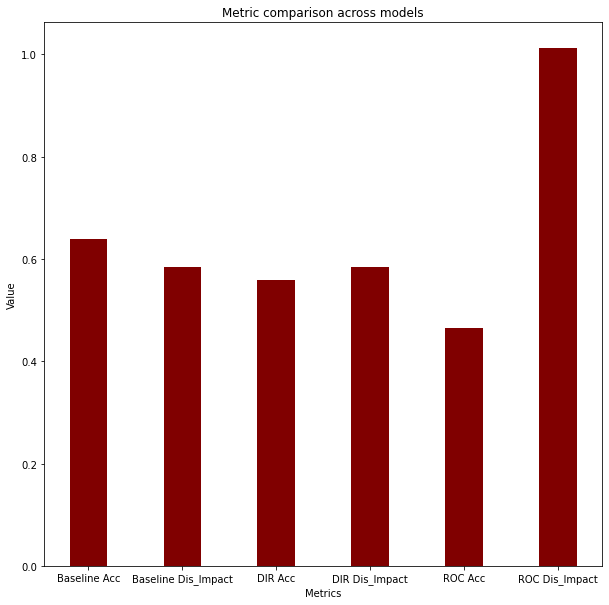

In [110]:
metrics_list = [accuracy, Disparate_Impact, result_dir[0][0], result_dir[0][2], results_roc_knn[4][0], results_roc_knn[4][1]]

metrics_dict = {'Baseline Acc':metrics_list[0], 'Baseline Dis_Impact':metrics_list[1], 'DIR Acc':metrics_list[2],
        'DIR Dis_Impact':metrics_list[3],'ROC Acc':metrics_list[4],'ROC Dis_Impact':metrics_list[5]}
x_values = list(metrics_dict.keys())
y_values = list(metrics_dict.values())
  
fig = plt.figure(figsize = (10, 10))
 
# creating the bar plot
plt.bar(x_values, y_values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Metric comparison across models")
plt.show()